In [3]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Input, Lambda, Conv2D, Dropout, Multiply, GlobalMaxPooling2D, MaxPooling2D, TimeDistributed, LSTM, Conv2DTranspose, concatenate, Concatenate, Dense, BatchNormalization, Activation, SeparableConv2D, add, Add, Multiply, SeparableConv2D, GlobalAveragePooling2D, DepthwiseConv2D, UpSampling2D, ZeroPadding2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt


# set global random seed
seed_value = 42

os.environ['PYTHONHASHSEED'] = str(seed_value)
import random
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [4]:
# Check if TensorFlow is using the Metal plugin (I'm using a Macbook Air with a built in 16-core Neural Engin, want to make sure I'm using that to ensure faster runtime)
print("TensorFlow is using Metal:", tf.config.list_physical_devices('GPU'))

TensorFlow is using Metal: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Data Preprocessing

In [5]:
# ---- Global Variables and Methods----
IMAGE_FOLDER = "images/"
SAL_MAP_FOLDER = "saliency_maps/"
CSV_FILE = 'image_types.csv'
IMG_SIZE = (224, 224, 3)

In [6]:
# ---- Data Generator ----
class DataGenerator(tf.keras.utils.Sequence):
    '''
    A custom data loader for the UI images and saliency maps, inheriting from tf.keras.utils.Sequence.
    For instance, can be used with the following methods:
        model.fit(train_data_gen, validation_data=val_data_gen, ...)
        predictions = model.predict(data_gen)
        loss, mae = model.evaluate(data_gen)
    '''
    def __init__(self, image_folder, sal_map_folder, filenames, batch_size=1, shuffle=True, sample_size=None):
        '''
        Constructor:
            image_folder (str): Path to the folder containing input images.
            sal_map_folder (str): Path to the folder containing saliency maps.
            filenames (list): List of filenames to include in this generator.
            batch_size (int): Number of samples per batch.
            shuffle (bool): Whether to shuffle the data at the end of each epoch.
            sample_size (int): Number of samples to use (for debugging).
        '''
        self.image_folder = image_folder # string, path to the folder containing input images
        self.sal_map_folder = sal_map_folder # string, path to the folder containing saliency maps
        self.batch_size = batch_size # int, number of samples per batch
        self.filenames = filenames # list of filenames (shared between the input images and their corresponding saliency maps) to convert to data
        self.sample_size = sample_size
        self.shuffle = shuffle # boolean, if using random shuffle each epoch

        # Limit the dataset to a (smaller) sample_size if specified
        if self.sample_size and self.sample_size<len(self.filenames):
            self.filenames = self.filenames[:self.sample_size]

        self.on_epoch_end() # random shuffle

    def on_epoch_end(self): # if using random shuffle each epoch
        '''If shuffle=True, shuffles the list of filenames to randomize the order of data for the next epoch (automatically called by Keras)'''
        if self.shuffle:
            np.random.shuffle(self.filenames)

    def __len__(self):
        '''Returns the number of batches per epoch'''
        return int(np.floor(len(self.filenames) / self.batch_size))

    def __getitem__(self, index):
        '''
        Generates one batch of data given the index of the batch (automatically called by Keras)
        Returns tuple (X, Y), both normalized to [0,1]
        X: batch of input images of shape (batch_size, height, width, channels)
        Y: batch of corresponding saliency maps of shape (batch_size, height, width, 1)
        
        Can be called using the [] indexing operator
        '''
        # select a subset of filenames for the current batch
        batch_files = self.filenames[index * self.batch_size:(index + 1) * self.batch_size]

        # load and preprocess the images and saliency maps for the specified batch
        return self.__data_generation(batch_files)
    
    def __data_generation(self, batch_files):
        '''
        Load and preprocess the images and saliency maps.
        Returns tuple (X, Y), both normalized to [0,1]
        X: batch of input images of shape (batch_size, height, width, channels)
        Y: batch of corresponding saliency maps of shape (batch_size, height, width, 1)
        '''
        X, Y = [], []
        for file in batch_files:
            # UI image
            img_path = os.path.join(self.image_folder, file)
            img = load_img(img_path, target_size=IMG_SIZE[:2]) # load and resize image to IMG_SIZE
            img = img_to_array(img) / 255.0 # convert images to arrays and normalize them to [0,1]
            
            # corresponding saliency map (grayscale)
            sal_path = os.path.join(self.sal_map_folder, file)
            sal_img = load_img(sal_path, target_size=IMG_SIZE[:2], color_mode="grayscale") # load and resize image to IMG_SIZE
            sal_img = img_to_array(sal_img) / 255.0 # convert images to arrays and normalize them to [0,1], use normalize()????
            
            X.append(img)
            Y.append(sal_img)

        return np.array(X), np.array(Y) # convert from list to np.arrays
    
    def saliency_binary_proportion(self):
        '''
        Calculates the average proportion of pixel values > 0.5 to pixel values <= 0.5
        in the target saliency maps (Y) across all batches in the generator.
        '''
        proportion = 0.0
        n_batches = len(self)
        N = IMG_SIZE[0]*IMG_SIZE[1] # image size, total number of pixels per map

        for i in range(n_batches):
            # Get the current batch of data
            _, Y = self[i]
            
            # Calculate the number of pixels > 0.5 in the saliency maps (Y)
            pixels_gt_0_5 = np.sum(Y > 0.5)

            # The total number of pixels in the saliency maps (Y)
            total_pixels = self.batch_size*N
            
            # Accumulate the proportion of salient pixels
            proportion += (pixels_gt_0_5 / total_pixels)

        # Calculate the average proportion across all batches
        return proportion / n_batches

In [7]:
# ---- Handle Missing Data ----
# Load the CSV file into a DataFrame
df = pd.read_csv(CSV_FILE, sep=',')

# Get the list of filenames from the CSV file, the image folder, and the saliency map folder
csv_filenames = set(df["Image Name"])
image_filenames = set(os.listdir(IMAGE_FOLDER))
sal_map_filenames = set(os.listdir(SAL_MAP_FOLDER))

print(f"There are {len(csv_filenames)} filenames in the CSV file.")
print(f"There are {len(image_filenames)} filenames in the Image folder.")
print(f"There are {len(sal_map_filenames)} filenames in the Saliency Map folder.")


# Find filenames that are missing in any of the three locations
missing_files = (csv_filenames | image_filenames | sal_map_filenames) - (csv_filenames & image_filenames & sal_map_filenames)

# Print missing filenames
if missing_files:
    print("The following filenames are missing in one or more locations:")
    for filename in missing_files:
        print(filename)
else:
    print("All filenames are present in all three locations.")

# Remove missing filenames from the CSV file
df = df[~df['Image Name'].isin(missing_files)]

print(f"Removed {len(missing_files)} filenames from the CSV file.\n")
print(f'Remaining Number of Data Samples:{df.shape[0]}')
print(f'Remaining Number of Desktop Samples:{df[df["Category"] == "desktop"].shape[0]}')
print(f'Remaining Number of Mobile Samples:{df[df["Category"] == "mobile"].shape[0]}')
print(f'Remaining Number of Web Samples:{df[df["Category"] == "web"].shape[0]}')
print(f'Remaining Number of Poster Samples:{df[df["Category"] == "poster"].shape[0]}')

There are 1463 filenames in the CSV file.
There are 1483 filenames in the Image folder.
There are 1924 filenames in the Saliency Map folder.
The following filenames are missing in one or more locations:
51f12a.jpg
c4b8a0.png
abc926.png
d70468.jpg
cd9e29.jpg
6d8534.png
511db2.png
592b58.png
35c062.png
4ae90b.jpg
4e81ec.png
6eb290.jpg
c40db1.jpg
576a9f.jpg
5d47cf.jpg
7dd59a.jpg
4bcfc3.png
fdc3d7.png
67225a.png
c83c32.png
35aa58.png
c75d3f.jpg
5bdff0.jpg
dbdbed.jpg
e129e6.jpg
eb334e.png
e1f7b0.jpg
d205d8.png
7dea7a.jpg
e4f360.jpg
fc4494.jpg
5b5e85.jpg
e82dd7.png
e624e7.jpg
eb34f4.png
592d83.png
db81dc.png
c1ad1f.jpg
c4b437.png
7decae.jpg
c9ab98.jpg
ab4eb4.png
58033d.jpg
4e729d.png
e39798.png
61707e.png
51db8e.png
7aad84.png
ab791d.png
ce9bfe.png
c9e860.png
51f811.png
fb0956.png
4b2bd1.png
e3d6fa.png
ce5b5c.png
e5174e.jpg
edbb42.png
7e01b8.png
5b51c9.jpg
c7db2d.png
5bfe3d.png
51f8bb.jpg
7c4cae.jpg
c9fe43.png
e102af.png
6f401f.jpg
eb0400.png
f2cbaa.jpg
e99f26.png
e471e8.png
4bb6dd.png
c6a6d

In [ ]:
# Initialize the training, validation, testing DataGenerators
data_gen_all = DataGenerator(IMAGE_FOLDER, SAL_MAP_FOLDER, df['Image Name'].tolist(), batch_size = 1)
data_gen_desktop = DataGenerator(IMAGE_FOLDER, SAL_MAP_FOLDER, df[df['Category'] == "desktop"]['Image Name'].tolist())
data_gen_poster = DataGenerator(IMAGE_FOLDER, SAL_MAP_FOLDER, df[df['Category'] == "poster"]['Image Name'].tolist())
data_gen_mobile = DataGenerator(IMAGE_FOLDER, SAL_MAP_FOLDER, df[df['Category'] == "mobile"]['Image Name'].tolist())
data_gen_web = DataGenerator(IMAGE_FOLDER, SAL_MAP_FOLDER, df[df['Category'] == "web"]['Image Name'].tolist())

# View the average proportion of salient pixels per map in the data
print('Average proportion of salient pixels per map in...')
print('The entire dataset: ', data_gen_all.saliency_binary_proportion())
print('The desktop dataset: ', data_gen_desktop.saliency_binary_proportion())
print('The poster dataset: ', data_gen_poster.saliency_binary_proportion())
print('The mobile dataset: ', data_gen_mobile.saliency_binary_proportion())
print('The web dataset: ', data_gen_web.saliency_binary_proportion())

# free the temporary data generators
del data_gen_all, data_gen_desktop, data_gen_poster, data_gen_mobile, data_gen_web

In [8]:
# ---- Initialize DataLoaders ----

# Filter by category if needed (desktop, poster, mobile, web) !!!
df = df[df['Category'] == "desktop"]

# Split the training data by randomly selecting valid_size*100% of the training data for validation
train_files = df[df['Train/Test'] == 'Train']['Image Name'].tolist()
valid_size = 0.2 # Split ratio
valid_indices = np.random.choice(len(train_files), int(len(train_files) * valid_size), replace=False)

# Get the list of...
valid_files = [train_files[i] for i in valid_indices] # validation filenames
train_files = [train_files[i] for i in range(len(train_files)) if i not in valid_indices] # training filenames
test_files = df[df['Train/Test'] == 'Test']['Image Name'].tolist() # testing filenames

# Check the number of batches in each generator
print("Number of training samples:", len(train_files))
print("Number of validation samples:", len(valid_files))
print("Number of test samples:", len(test_files))

# Initialize the training, validation, testing DataGenerators
train_data_gen = DataGenerator(IMAGE_FOLDER, SAL_MAP_FOLDER, train_files, batch_size = 16)
valid_data_gen = DataGenerator(IMAGE_FOLDER, SAL_MAP_FOLDER, valid_files, shuffle=False, batch_size = 16) # no need to shuffle validation data
test_data_gen = DataGenerator(IMAGE_FOLDER, SAL_MAP_FOLDER, test_files, shuffle=False, batch_size = 16) # no need to shuffle test data

# Check the number of batches in each generator
print("Number of training batches:", len(train_data_gen))
print("Number of validation batches:", len(valid_data_gen))
print("Number of test batches:", len(test_data_gen))

# View the first batch of training data
batch1 = train_data_gen[0]
print("Training input batch shape:", batch1[0].shape)
print("Training saliency batch shape:", batch1[1].shape)

# View the average proportion of salient pixels in target maps of training data
print('Average proportion of salient pixels in target maps: ', train_data_gen.saliency_binary_proportion())

Number of training samples: 276
Number of validation samples: 69
Number of test samples: 18
Number of training batches: 17
Number of validation batches: 4
Number of test batches: 1
Training input batch shape: (16, 224, 224, 3)
Training saliency batch shape: (16, 224, 224, 1)
Average proportion of salient pixels in target maps:  0.027322427994635357


using 0.5 as a binary classification threshold for pixel saliency, even though this isn't a classification problem, this illustrates how sparse the target output is (like how class imbalance in target data is difficult)

# Defining Methods for Evaluating the Model Training Process and Performance

In [9]:
# Plot the learning curve
def plot_learning_curve(history):
    # Extract loss and metrics from the history object
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    
    # Plot the loss curve (use combined loss!!!)
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
        
    plt.tight_layout()
    plt.show()

In [10]:
# Function to visualize the original image, ground truth saliency map, and predicted saliency map
def visualize_results(model, data_gen, num_samples=5):
    plt.figure(figsize=(15, 5 * num_samples))
    
    for i in range(num_samples):
        # Get a new batch for each sample
        X, Y_sal = data_gen[i % len(data_gen)]  # Cycle through batches if num_samples > batch_size
        
        # Predict saliency map
        Y_pred = model.predict(X, verbose=0)
        
        # Original Image (already resized to IMG_SIZE in DataGenerator)
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(X[0])  # Only use the first sample in the batch
        plt.title("Original Image")
        plt.axis('off')
        
        # Ground Truth Saliency Map (already resized to IMG_SIZE in DataGenerator)
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(Y_sal[0].squeeze(), cmap='gray')  # Only use the first sample in the batch
        plt.title("Ground Truth Saliency Map")
        plt.axis('off')
        
        # Predicted Saliency Map (already resized to IMG_SIZE in DataGenerator)
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(Y_pred[0].squeeze(), cmap='gray')  # Only use the first sample in the batch
        plt.title("Predicted Saliency Map")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Defining the Loss Terms and Model Evaluation Metrics

### Define various normalization and scaling functions

In [11]:
# ----------------------------- Scaling Functions ----------------------------- 

def batch_min_max_scaling(heatmap):
    '''
    Min-Max scaling
    This method is from 'sal_imp_utilities.py' written by the UEyes team, called 'normalize'.
    '''

    # Apply mimaxscaler algorithm (https://en.wikipedia.org/wiki/Feature_scaling#Rescaling_(min-max_normalization))
    heatmap = (heatmap - K.min(heatmap)) / (K.epsilon() + K.max(heatmap) - K.min(heatmap))
    
    return heatmap

def min_max_scaling(heatmap):
    '''
    Min-Max scaling
    '''
    # Compute min and max for each sample in the batch
    min_vals = K.min(heatmap, axis=[1, 2], keepdims=True)  # Shape: (batch_size, 1, 1, 1)
    max_vals = K.max(heatmap, axis=[1, 2], keepdims=True)  # Shape: (batch_size, 1, 1, 1)

    # Apply min-max scaling to each sample
    heatmap = (heatmap - min_vals) / (K.epsilon() + max_vals - min_vals)

    return heatmap

def max_scaling(heatmap):
    '''
    Max scaling
    This method is adapted from 'sal_imp_utilities.py' written by the UEyes team.
    '''

    max_heatmap = K.repeat_elements(K.expand_dims(K.repeat_elements(K.expand_dims(K.max(heatmap, axis=[1,2]), axis=2),
                                                                   IMG_SIZE[0], axis=1), axis=2), IMG_SIZE[1], axis=2)
    heatmap /= (max_heatmap + K.epsilon())
    
    return heatmap




# ----------------------------- Normalization Functions ----------------------------- 

def batch_sum_normalize(heatmap):
    '''
    Sum Normalize heatmap values in the [0,1] range across the tensor (batch).
    '''
    heatmap /= (K.epsilon() + K.sum(heatmap))

    return heatmap

def sum_normalize(heatmap):
    '''
    Sum Normalize heatmap values in the [0,1] range across each map in the tensor (batch).
    '''

    heatmap /= (K.epsilon() + K.sum(heatmap, axis=[1, 2], keepdims=True))

    return heatmap

def whitening(heatmap):
    '''
    Apply whitening algorithm, which is basically mean-std normalization but for each pixel???
    See https://en.wikipedia.org/wiki/Whitening_transformation
    This method is from 'sal_imp_utilities.py' written by the UEyes team, called 'whiten'
    '''

    # Convert input to TensorFlow tensor if it's a NumPy array
    if isinstance(heatmap, np.ndarray):
        heatmap = tf.convert_to_tensor(heatmap)

    # Compute mean and std over the spatial dimensions (height and width)
    heatmap_mean = K.mean(heatmap, axis=[1, 2], keepdims=True)  # Shape: (batch_size, 1, 1, channels)
    heatmap_std = K.std(heatmap, axis=[1, 2], keepdims=True)    # Shape: (batch_size, 1, 1, channels)

    # Normalize the heatmap
    return (heatmap - heatmap_mean) / (heatmap_std + K.epsilon())

def mean_std_normalize(heatmap):
    '''
    Zero mean and unit variance normalization across each map in the tensor (batch).
    This method is from 'sal_imp_utilities.py' written by the UEyes team
    '''

    # Convert input to TensorFlow tensor if it's a NumPy array
    if isinstance(heatmap, np.ndarray):
        heatmap = tf.convert_to_tensor(heatmap)

    # Flatten spatial dimensions (height * width)
    heatmap_flat = K.batch_flatten(heatmap)  # Shape: (batch_size, height * width)

    # Compute mean and std across all spatial positions
    heatmap_mean = K.mean(heatmap_flat, axis=-1, keepdims=True)  # Shape: (batch_size, 1)
    heatmap_std = K.std(heatmap_flat, axis=-1, keepdims=True)    # Shape: (batch_size, 1)

    # Reshape mean and std for broadcasting back to original shape
    heatmap_mean = K.reshape(heatmap_mean, (-1, 1, 1, 1))  # (batch_size, 1, 1, 1)
    heatmap_std = K.reshape(heatmap_std, (-1, 1, 1, 1))    # (batch_size, 1, 1, 1)

    # Normalize the heatmap
    return (heatmap - heatmap_mean) / (heatmap_std + K.epsilon())

### Define various loss functions

In [12]:
# ------------------------------------ Losses used by UEyes Team ------------------------------------

mse = tf.keras.losses.MeanSquaredError()


def nss_(y_true, y_pred, scaler=False):
    """
    Compute Normalized Scanpath Saliency (NSS) score.
    This method is from 'losses_keras2.py' written by the UEyes team.
    """
    ax = 1

    if K.all(K.equal(K.sum(K.sum(y_true, axis=ax), axis=ax), 0.0)):
        return 0.0

    max_y_pred = K.repeat_elements(K.expand_dims(K.repeat_elements(K.expand_dims(K.max(K.max(y_pred, axis=ax), axis=ax), axis=ax+1), IMG_SIZE[0], axis=ax), axis=ax+1), IMG_SIZE[1], axis=ax+1)

    y_pred /= (max_y_pred + K.epsilon())

    y_pred_flatten = K.batch_flatten(y_pred)

    y_mean = K.mean(y_pred_flatten, axis=-1)
    y_mean = K.repeat_elements(K.expand_dims(K.repeat_elements(K.expand_dims(K.expand_dims(y_mean)), IMG_SIZE[0], axis=ax)), IMG_SIZE[1], axis=ax+1)

    y_std = K.std(y_pred_flatten, axis=-1)
    y_std = K.repeat_elements(K.expand_dims(K.repeat_elements(K.expand_dims(K.expand_dims(y_std)), IMG_SIZE[0], axis=ax)), IMG_SIZE[1], axis=ax+1)

    y_pred = (y_pred - y_mean) / (y_std + K.epsilon())

    den = K.sum(K.sum(y_true * y_pred, axis=ax), axis=ax)
    nom = K.sum(K.sum(y_true, axis=ax), axis=ax) + K.epsilon()

    nss_out = den/nom
    if scaler:
        nss_out = K.mean(nss_out)

    return  nss_out

def nss(y_true, y_pred, scaler=False):
    """
    Compute Normalized Scanpath Saliency (NSS) score.
    This method is adapted from 'losses_keras2.py' written by the UEyes team.
    """

    if K.all(K.equal(K.sum(y_true, axis=[1,2]), 0.0)):
        return tf.convert_to_tensor(0.0) # 0.0

    y_pred = max_scaling(y_pred) # why use max-scaling at all before normalization???
    y_pred = mean_std_normalize(y_pred)

    den = K.sum(y_true * y_pred, axis=[1,2])
    nom = K.sum(y_true, axis=[1,2]) + K.epsilon()

    nss_out = den/nom

    if scaler:
        nss_out = K.mean(nss_out)

    return  nss_out

def nss_loss(y_true, y_pred):
    """
    Compute Normalized Scanpath Saliency (NSS) score.
    This method is adapted from 'losses_keras2.py' written by the UEyes team.
    """

    return  -nss(y_true, y_pred)


def correlation_coefficient_(y_true, y_pred, scaler=False):
    """
    Compute Cross-Correlation (CC) score.
    This method is from 'losses_keras2.py' written by the UEyes team.
    """
    max_y_pred = K.repeat_elements(K.expand_dims(K.repeat_elements(K.expand_dims(K.max(K.max(y_pred, axis=1), axis=1), axis=1),
                                                                   IMG_SIZE[0], axis=1), axis=2), IMG_SIZE[1], axis=2)
    y_pred /= (max_y_pred + K.epsilon())

    sum_y_true = K.repeat_elements(K.expand_dims(K.repeat_elements(K.expand_dims(K.sum(K.sum(y_true, axis=1), axis=1), axis=1),
                                                                   IMG_SIZE[0], axis=1), axis=2), IMG_SIZE[1], axis=2)
    sum_y_pred = K.repeat_elements(K.expand_dims(K.repeat_elements(K.expand_dims(K.sum(K.sum(y_pred, axis=1), axis=1), axis=1),
                                                                   IMG_SIZE[0], axis=1), axis=2), IMG_SIZE[1], axis=2)
    y_true /= (sum_y_true + K.epsilon())
    y_pred /= (sum_y_pred + K.epsilon())

    N = IMG_SIZE[0] * IMG_SIZE[1]
    sum_prod = K.sum(K.sum(y_true * y_pred, axis=1), axis=1)
    sum_x = K.sum(K.sum(y_true, axis=1), axis=1)
    sum_y = K.sum(K.sum(y_pred, axis=1), axis=1)
    sum_x_square = K.sum(K.sum(K.square(y_true), axis=1), axis=1)
    sum_y_square = K.sum(K.sum(K.square(y_pred), axis=1), axis=1)

    num = sum_prod - ((sum_x * sum_y) / N)
    den = K.sqrt((sum_x_square - K.square(sum_x) / N) * (sum_y_square - K.square(sum_y) / N)) + K.epsilon()

    if scaler: 
        return K.mean(num / den)
    else:
        return num / den


def correlation_coefficient(y_true, y_pred, scaler=False):
    """
    Compute Correlation Coefficient score, range is [0,1]
    This method is adapted from 'losses_keras2.py' written by the UEyes team.
    """

    #y_pred = max_scaling(y_pred) # idk why use max-scaling at all before normalization, makes little difference???
    y_pred = sum_normalize(y_pred)
    y_true = sum_normalize(y_true)

    N = IMG_SIZE[0] * IMG_SIZE[1]
    sum_prod = K.sum(y_true * y_pred, axis=[1,2])
    sum_x = K.sum(y_true, axis=[1,2])
    sum_y = K.sum(y_pred, axis=[1,2])
    sum_x_square = K.sum(K.square(y_true), axis=[1,2])
    sum_y_square = K.sum(K.square(y_pred), axis=[1,2])

    num = sum_prod - ((sum_x * sum_y) / N)
    den = K.sqrt((sum_x_square - K.square(sum_x) / N) * (sum_y_square - K.square(sum_y) / N)) + K.epsilon()

    if scaler: 
        return K.mean(num / den) 
    else:
        return num / den

def correlation_coefficient_loss(y_true, y_pred):
    return -correlation_coefficient(y_true, y_pred)


def batch_min_max_sum_normalize(heatmap):
    '''
    Min-Max scaling
    Sum Normalize heatmap values in the [0,1] range across entire tensor (batch).
    This method is from 'sal_imp_utilities.py' written by the UEyes team, called 'normalize'.
    '''

    # Apply mimaxscaler algorithm (https://en.wikipedia.org/wiki/Feature_scaling#Rescaling_(min-max_normalization))
    heatmap = (heatmap - K.min(heatmap)) / (K.epsilon() + K.max(heatmap) - K.min(heatmap))

    # Sum normalization
    heatmap /= (K.epsilon() + K.sum(heatmap))
    
    return heatmap

def similarity_(y_true, y_pred):
    '''
    Compute Similarity score.
    This method is from 'losses_keras2.py' written by the UEyes team.
    '''
    y_pred = batch_min_max_sum_normalize(y_pred)
    y_true = batch_min_max_sum_normalize(y_true)

    return K.sum(K.minimum(y_pred, y_true))


def similarity(y_true, y_pred):
    '''
    Compute Similarity score, range is [0,1]
    Intersection/overlap between the predicted and the ground-truth saliency maps
    the sum of the minimum value of the normalized predicted map and ground-truth map. 
    The absence of saliency values points to zero similarity (sensitive to failed detection of saliency points)

    This method is adapted from 'losses_keras2.py' written by the UEyes team.
    '''

    # original normalization implementation, not sure what the point of min-max scaling is before the sum normalization, makes little difference???
    #y_pred = batch_min_max_scaling(y_pred)
    #y_true = batch_min_max_scaling(y_true)

    # sum normalization across each map so that the similarity score is [0,1] per batch of maps
    y_pred = batch_sum_normalize(y_pred)
    y_true = batch_sum_normalize(y_true)

    return K.sum(K.minimum(y_pred, y_true))

def similarity_loss(y_true, y_pred):
    return -similarity(y_true,y_pred)


def combiined_similarity_loss(y_true, y_pred):
    '''
    Combined both the original similarity loss and inverted similarity loss.
    '''
    return -similarity(y_true, y_pred)-similarity_opposite(y_true, y_pred)


kl = tf.keras.losses.KLDivergence() # Initialize the KL Divergence loss instance once
def kl_divergence(y_true, y_pred):
    '''
    Compute Kullback-Leibler divergence loss, range is [0,inf)
    Quantifies the difference between the distributions of the saliency map prediction and the ground truth (the smaller the better)

    This method is from 'losses_keras2.py' written by the UEyes team.
    '''
    #y_pred = max_scaling(y_pred) # used axis=1??? also idk why use max-scaling at all before normalization, makes no difference???
    y_pred = sum_normalize(y_pred)
    y_true = sum_normalize(y_true)

    # min-max scaling s.t. pixels of maps in each batch is bt [0,1]
    #y_pred = batch_min_max_scaling(y_pred)
    #y_true = batch_min_max_scaling(y_true)
    
    return kl(y_true,y_pred) # scale up between the range in practice is very small


def kl_divergence_(y_true, y_pred):
    '''
    Compute Kullback-Leibler divergence loss.
    This method is from 'losses_keras2.py' written by the UEyes team.
    '''

    max_y_pred = K.repeat_elements(K.expand_dims(K.repeat_elements(K.expand_dims(K.max(K.max(y_pred, axis=1), axis=1), axis=1),
                                                                   IMG_SIZE[0], axis=1), axis=2), IMG_SIZE[1], axis=2)
    y_pred /= max_y_pred

    sum_y_true = K.repeat_elements(K.expand_dims(K.repeat_elements(K.expand_dims(K.sum(K.sum(y_true, axis=1), axis=1), axis=1),
                                                                   IMG_SIZE[0], axis=1), axis=2), IMG_SIZE[1], axis=2)
    sum_y_pred = K.repeat_elements(K.expand_dims(K.repeat_elements(K.expand_dims(K.sum(K.sum(y_pred, axis=1), axis=1), axis=1),
                                                                   IMG_SIZE[0], axis=1), axis=2), IMG_SIZE[1], axis=2)
    y_true /= (sum_y_true + K.epsilon())
    y_pred /= (sum_y_pred + K.epsilon())
    
    return kl(y_true,y_pred)


# ------------------------------------ New Losses to Consider ------------------------------------

mae = tf.keras.losses.MeanAbsoluteError()
"""
Compute the MAE between two (batches of) saliency maps y and y'.
"""


cs_ = tf.keras.metrics.CosineSimilarity(axis=[1,2])
def cosine_similarity(y_true, y_pred):
    """
    Compute the cosine similarity between two (batches of) saliency maps y and y'.
    """
    return cs_(y_true, y_pred)

cs_loss = tf.keras.losses.CosineSimilarity(axis=[1,2])
def cosine_similarity_loss(y_true, y_pred):
    return cs_loss(y_true, y_pred)


def similarity_opposite(y_true, y_pred):
    '''
    Compute Similarity score, range is [0,1]
    Intersection/overlap between the predicted and the ground-truth saliency maps
    the sum of the minimum value of the inverted normalized predicted map and ground-truth map. 
    The absence of non-salient values points to zero similarity (sensitive to failed detection of non-salient points)

    This method is adapted from 'losses_keras2.py' written by the UEyes team.
    '''

    # original normalization implementation, not sure what the point of min-max scaling is before the sum normalization, makes little difference???
    #y_pred = batch_min_max_scaling(y_pred)
    #y_true = batch_min_max_scaling(y_true)

    # invert the maps
    y_pred = -y_pred+1
    y_true = -y_true+1

    # sum normalization across each map so that the similarity score is [0,1] per batch of maps
    y_pred = batch_sum_normalize(y_pred)
    y_true = batch_sum_normalize(y_true)

    return K.sum(K.minimum(y_pred, y_true))

def similarity_opposite_loss(y_true, y_pred):
    return -similarity_opposite(y_true,y_pred)

def entropy(y_true, y_pred):
    """
    TODO: binary focal cross entropy from keras
    """
    return

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2025-03-11 12:51:35.678740: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-11 12:51:35.679040: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Define various evaluation metrics

In [14]:
# ------------------------------------ Metrics used by UEyes Team ------------------------------------

auc_ROC = tf.keras.metrics.AUC(num_thresholds=100) # Initialize the AUC metric instance once
def auc_judd(y_true, y_pred):
    """
    Compute AUC-Judd score (from the ROC curve).
    """
    y_true = K.batch_flatten(y_true)  # Flatten to (batch_size, height * width,)
    y_pred = K.batch_flatten(y_pred)  # Flatten to (batch_size, height * width,)

    auc_ROC.update_state(y_true, y_pred)
    return auc_ROC.result()


def information_gain(y_true, y_pred, baseline="uniform"):
    """
    Compute Information Gain (IG) score. 
    (TODO: check the definition bc UEyes didn't provide implementation)!!!

    Positive IG: Indicates that the predicted saliency map provides more information than the baseline.
    Zero IG: Indicates that the predicted saliency map provides the same amount of information as the baseline.
    Negative IG: Indicates that the predicted saliency map provides less information than the baseline.
    """

    # Define the baseline ???
    y_baseline = tf.ones_like(y_true) / (IMG_SIZE[0] * IMG_SIZE[1])
    if baseline == "uniform":
        # Uniform distribution (1/N)
        y_baseline = tf.ones_like(y_true) / (IMG_SIZE[0] * IMG_SIZE[1])
    elif baseline == "center":
        # Create a center bias map (Gaussian centered at the image center)
        x = tf.linspace(-1.0, 1.0, 224)
        y = tf.linspace(-1.0, 1.0, 224)
        x, y = tf.meshgrid(x, y)
        y_baseline = tf.exp(-(x**2 + y**2) / 0.1)  # Gaussian kernel
        y_baseline = y_baseline / (K.sum(y_baseline) + K.epsilon())  # Normalize
        y_baseline = tf.expand_dims(y_baseline, axis=-1)  # Add channel dimension
        y_baseline = tf.expand_dims(y_baseline, axis=0)  # Add batch dimension

    
    # Sum normalization (so that the saliency maps are normalized to sum to 1, i.e., are probability distributions) ???
    y_pred = sum_normalize(y_pred)
    y_true = sum_normalize(y_true)

    # Compute log-likelihood ratio
    log_ratio = K.log((y_pred + K.epsilon()) / (y_baseline + K.epsilon()))

    # Compute IG
    return K.mean(K.sum(y_true * log_ratio, axis=[1, 2]))


# ------------------------------------ New Metrics to Consider ------------------------------------

auc_PR_ = tf.keras.metrics.AUC(num_thresholds=100, curve='PR') # Initialize the AUC metric instance once
def auc_PR(y_true, y_pred):
    """
    Compute AUC score (from the precision-recall curve).
    """

    auc_PR_.update_state(y_true, y_pred)
    return auc_PR_.result()


### Observe the behavior of the evaluation metrics and loss functions

In [13]:
pd.reset_option('display.precision')

# batch_size of training data generator
batch_size = 16

# Create fully salient tensor (all 1's)
all_salient = tf.ones((batch_size, IMG_SIZE[0], IMG_SIZE[1], 1), dtype=tf.float32)

# Create fully non-salient tensor (all 0's)
not_salient = tf.zeros((batch_size, IMG_SIZE[0], IMG_SIZE[1], 1), dtype=tf.float32)

# Define the cases
cases = {
    "fully true positive": (all_salient, all_salient),
    "fully true negative": (not_salient, not_salient),
    "fully false negative": (all_salient, not_salient),
    "fully false positive": (not_salient, all_salient)
}

# Define the score methods implemented by us.
score_methods = {
    #"Mean Squared Error": mse,
    #"Mean Absolute Error": mae,
    "KL Divergence": kl_divergence,
    "Normalized Scanpath Saliency": nss,
    "Correlation Coefficient": correlation_coefficient,
    "Similarity": similarity,
    "Similarity (opposite)": similarity_opposite,
    "Cosine Similarity": cosine_similarity,
    "AUC-Judd": auc_judd,
    "AUC-PR": auc_PR,
    "Information Gain": information_gain
    #"combined_loss_UEyes": combined_loss_UEyes,
    #"combined_loss_UEyes_2": combined_loss_UEyes_2
}

# Create a table to store results
behavior = {case: {} for case in cases}

# Evaluate scores for each case and method
for case, (y_true, y_pred) in cases.items():
    for method_name, method in score_methods.items():
        if method_name=="Correlation Coefficient" or method_name=="Normalized Scanpath Saliency":
            behavior[case][method_name] = method(y_true, y_pred, scaler=True).numpy()
        else:
            behavior[case][method_name] = method(y_true, y_pred).numpy()

pd.DataFrame(behavior)

#TODO: KL, NSS, CC, SIM_oppo, CS aren't behaving right

fully true positive  fully true negative  \
KL Divergence                            0.000000                  0.0   
Normalized Scanpath Saliency             0.000000                  0.0   
Correlation Coefficient                  0.000418                  0.0   
Similarity                               1.000000                  0.0   
Similarity (opposite)                    0.000000                  1.0   
Cosine Similarity                        1.000000                  0.5   
AUC-Judd                                 0.000000                  1.0   
AUC-PR                                   1.000000                  1.0   
Information Gain                         0.000000                  0.0   

                              fully false negative  fully false positive  
KL Divergence                             0.000106         -5.294804e-07  
Normalized Scanpath Saliency              0.000000          0.000000e+00  
Correlation Coefficient                   0.000000          0.000000e+00  
Similarity                                0.000000          0.000000e+00  
Similarity (opposite)                     0.000000          0.000000e+00  
Cosine Similarity                         0.333333          2.499999e-01  
AUC-Judd                                  0.750000          5.000000e-01  
AUC-PR                                    0.887327          5.000000e-01  
Information Gain                         -5.299806          0.000000e+00

In [14]:
# Define the score methods implemented by the UEyes team.
score_methods = {
    "KL Divergence": kl_divergence_,
    "Normalized Scanpath Saliency": nss_,
    "Correlation Coefficient": correlation_coefficient_,
    "Similarity": similarity_
}

# Create a table to store results
behavior = {case: {} for case in cases}

# Evaluate scores for each case and method
for case, (y_true, y_pred) in cases.items():
    for method_name, method in score_methods.items():
        score = method(y_true, y_pred)
        if method_name=="Correlation Coefficient" or method_name=="Normalized Scanpath Saliency":
            score = method(y_true, y_pred, scaler=True)
        if not tf.is_tensor(score):
            score = tf.convert_to_tensor(score)
        behavior[case][method_name] = score.numpy()

pd.DataFrame(behavior)

fully true positive  fully true negative  \
KL Divergence                                 0.0            -0.000002   
Normalized Scanpath Saliency                  0.0             0.000000   
Correlation Coefficient                       0.0             0.000000   
Similarity                                    0.0             0.000000   

                              fully false negative  fully false positive  
KL Divergence                            -0.000216         -5.294804e-07  
Normalized Scanpath Saliency              0.000000          0.000000e+00  
Correlation Coefficient                   0.000000          0.000000e+00  
Similarity                                0.000000          0.000000e+00

# The Simplified Copycat UMSI++ Model

In [15]:
combined_metrics=[#'mse', # Mean Squared Error
                  #'mae', # Mean Squared Error
                    auc_judd,  # AUC-Judd (of ROC curve)
                    #auc_PR,  # AUC of PR curve
                    nss,       # Normalized Scanpath Saliency
                    information_gain,  # Information Gain
                    similarity,  # Similarity
                    correlation_coefficient,  # Absolute Correlation Coefficient
                    #cosine_similarity, # Cosine Similarity
                    kl_divergence]  # KL Divergence

pd.set_option('display.float_format', '{:.15f}'.format)
def train_test_performance(model):
    '''
    Display the model's performance on training data and test data across different metrics.
    '''
    # Compute performance on train data
    performance_train = {}
    for metric in model.metrics:
        result = metric.result()
        result = result.numpy().item()
        if isinstance(result, dict):
            performance_train.update(result)
        else:
            performance_train[metric.name] = result
    performance_train = pd.DataFrame(performance_train,index=['Train'])

    # Compute performance on test data
    performance_test = model.evaluate(test_data_gen,return_dict=True, verbose=0)
    performance_test = pd.DataFrame(performance_test,index=['Test'])

    # Provide results in a table    
    return pd.concat([performance_train, performance_test])

### Define the model architecture

In [16]:
# Define the UMSI++ model
def UMSI_simple(input_shape=(224, 224, 3)):
    # Input layer
    inputs = Input(shape=input_shape)
    
    # --------------------------
    # Encoder (Feature Extraction)
    # --------------------------
    # Block 1
    x1 = Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv1')(inputs)
    x1 = Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv2')(x1)
    p1 = MaxPooling2D((2, 2), name='block1_pool')(x1)
    
    # Block 2
    x2 = Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv1')(p1)
    x2 = Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv2')(x2)
    p2 = MaxPooling2D((2, 2), name='block2_pool')(x2)
    
    # Block 3
    x3 = Conv2D(128, (3, 3), activation='relu', padding='same', name='block3_conv1')(p2)
    x3 = Conv2D(128, (3, 3), activation='relu', padding='same', name='block3_conv2')(x3)
    p3 = MaxPooling2D((2, 2), name='block3_pool')(x3)
    
    # --------------------------
    # Bottleneck (Multi-Scale Feature Aggregation)
    # --------------------------
    bottleneck = Conv2D(256, (3, 3), activation='relu', padding='same', name='bottleneck_conv1')(p3)
    bottleneck = Conv2D(256, (3, 3), activation='relu', padding='same', name='bottleneck_conv2')(bottleneck)
    
    # --------------------------
    # Decoder (Saliency Map Reconstruction)
    # --------------------------
    # Block 4
    u4 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', name='block4_deconv')(bottleneck)
    u4 = concatenate([u4, x3], name='block4_concat')
    u4 = Conv2D(128, (3, 3), activation='relu', padding='same', name='block4_conv1')(u4)
    u4 = Conv2D(128, (3, 3), activation='relu', padding='same', name='block4_conv2')(u4)
    
    # Block 5
    u5 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', name='block5_deconv')(u4)
    u5 = concatenate([u5, x2], name='block5_concat')
    u5 = Conv2D(64, (3, 3), activation='relu', padding='same', name='block5_conv1')(u5)
    u5 = Conv2D(64, (3, 3), activation='relu', padding='same', name='block5_conv2')(u5)
    
    # Block 6
    u6 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', name='block6_deconv')(u5)
    u6 = concatenate([u6, x1], name='block6_concat')
    u6 = Conv2D(32, (3, 3), activation='relu', padding='same', name='block6_conv1')(u6)
    u6 = Conv2D(32, (3, 3), activation='relu', padding='same', name='block6_conv2')(u6)
    
    # --------------------------
    # Saliency Output
    # --------------------------
    saliency_output = Conv2D(1, (1, 1), activation='sigmoid', name='saliency_output')(u6)
    
    # --------------------------
    # Define the Model
    # --------------------------
    model = Model(inputs, saliency_output, name='UMSI_simple')  # Use a valid model name
    
    return model

### Define learning rate optimzer and early stopping for training

In [17]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) # Restore model weights from the epoch with the best value of val_loss. TODO: incorporate into trianing
opt = Adam(learning_rate=0.001)

### Train with NSS loss

Epoch 1/12


2025-03-11 00:25:09.969638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - ETA: 0s - loss: -0.3392 - mae: 0.5976

2025-03-11 00:25:23.921278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 18s 768ms/step - loss: -0.3392 - mae: 0.5976 - val_loss: -0.8762 - val_mae: 0.5477
Epoch 2/12
17/17 [==============================] - 12s 705ms/step - loss: -0.9765 - mae: 0.5365 - val_loss: -1.0633 - val_mae: 0.5337
Epoch 3/12
17/17 [==============================] - 12s 697ms/step - loss: -1.0948 - mae: 0.4784 - val_loss: -1.1272 - val_mae: 0.4461
Epoch 4/12
17/17 [==============================] - 12s 711ms/step - loss: -1.1303 - mae: 0.4630 - val_loss: -1.1468 - val_mae: 0.4315
Epoch 5/12
17/17 [==============================] - 12s 707ms/step - loss: -1.1645 - mae: 0.4436 - val_loss: -1.1688 - val_mae: 0.4639
Epoch 6/12
17/17 [==============================] - 12s 704ms/step - loss: -1.1840 - mae: 0.4483 - val_loss: -1.1765 - val_mae: 0.4514
Epoch 7/12
17/17 [==============================] - 12s 713ms/step - loss: -1.1961 - mae: 0.4486 - val_loss: -1.1699 - val_mae: 0.4465
Epoch 8/12
17/17 [==============================] - 12s 702ms/step

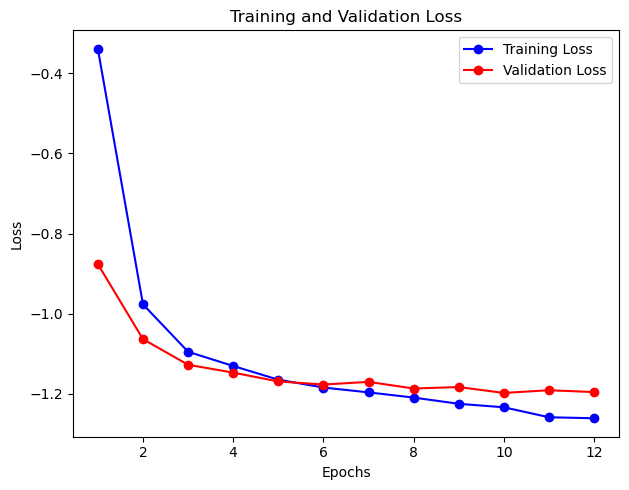

2025-03-11 00:27:39.941705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


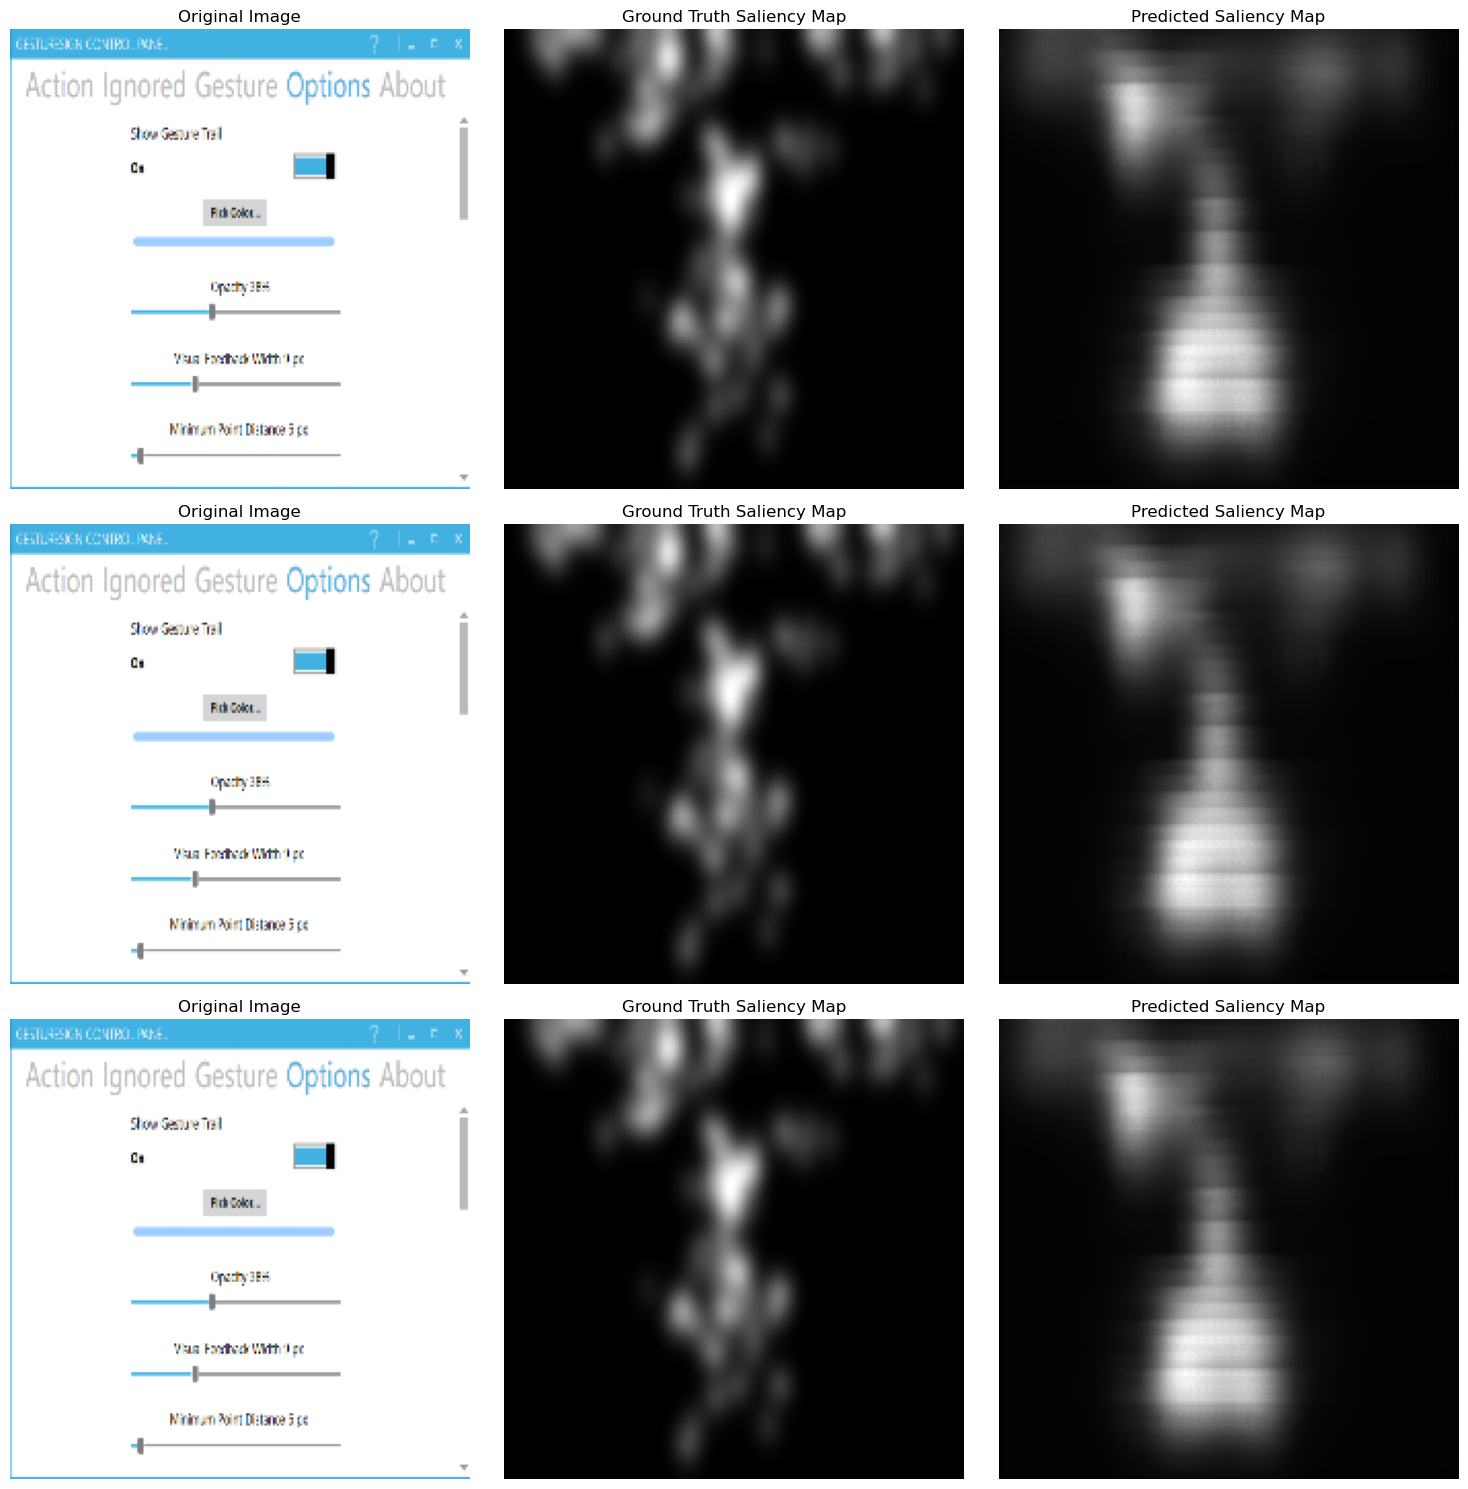

In [72]:
UMSI_nss = UMSI_simple(input_shape=(224, 224, 3))
UMSI_nss.compile(optimizer=opt, loss = nss_loss, metrics='mae')
history = UMSI_nss.fit(train_data_gen, validation_data=valid_data_gen, epochs=12, steps_per_epoch=len(train_data_gen), callbacks=[early_stopping]) #Train the model and capture the history
plot_learning_curve(history)
visualize_results(UMSI_nss, test_data_gen, num_samples=3) # 5 random test examples

### Train with KLD loss

Epoch 1/12


2025-03-11 11:15:26.407735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - ETA: 0s - loss: 0.0023 - mae: 0.5762

2025-03-11 11:15:42.288557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 19s 921ms/step - loss: 0.0023 - mae: 0.5762 - val_loss: 0.0021 - val_mae: 0.6550
Epoch 2/12
17/17 [==============================] - 13s 742ms/step - loss: 0.0021 - mae: 0.7612 - val_loss: 0.0021 - val_mae: 0.7775
Epoch 3/12
17/17 [==============================] - 13s 753ms/step - loss: 0.0019 - mae: 0.4934 - val_loss: 0.0017 - val_mae: 0.5386
Epoch 4/12
17/17 [==============================] - 13s 754ms/step - loss: 0.0016 - mae: 0.3491 - val_loss: 0.0015 - val_mae: 0.3180
Epoch 5/12
17/17 [==============================] - 13s 766ms/step - loss: 0.0013 - mae: 0.2051 - val_loss: 0.0013 - val_mae: 0.2235
Epoch 6/12
17/17 [==============================] - 13s 737ms/step - loss: 0.0012 - mae: 0.1338 - val_loss: 0.0012 - val_mae: 0.1592
Epoch 7/12
17/17 [==============================] - 13s 747ms/step - loss: 0.0012 - mae: 0.1282 - val_loss: 0.0012 - val_mae: 0.1128
Epoch 8/12
17/17 [==============================] - 12s 712ms/step - loss: 0.001

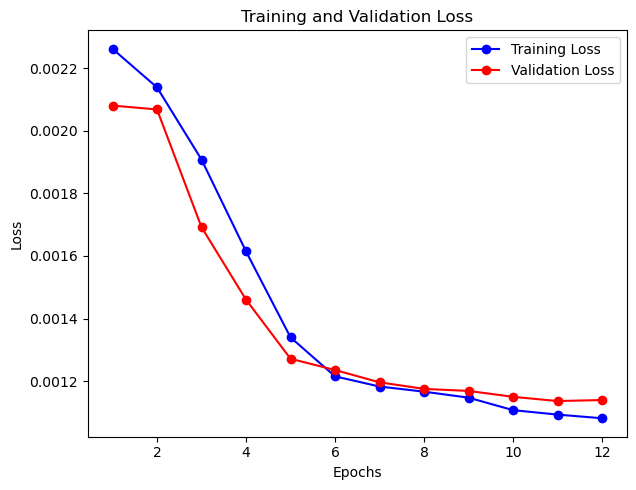

2025-03-11 11:18:06.149582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


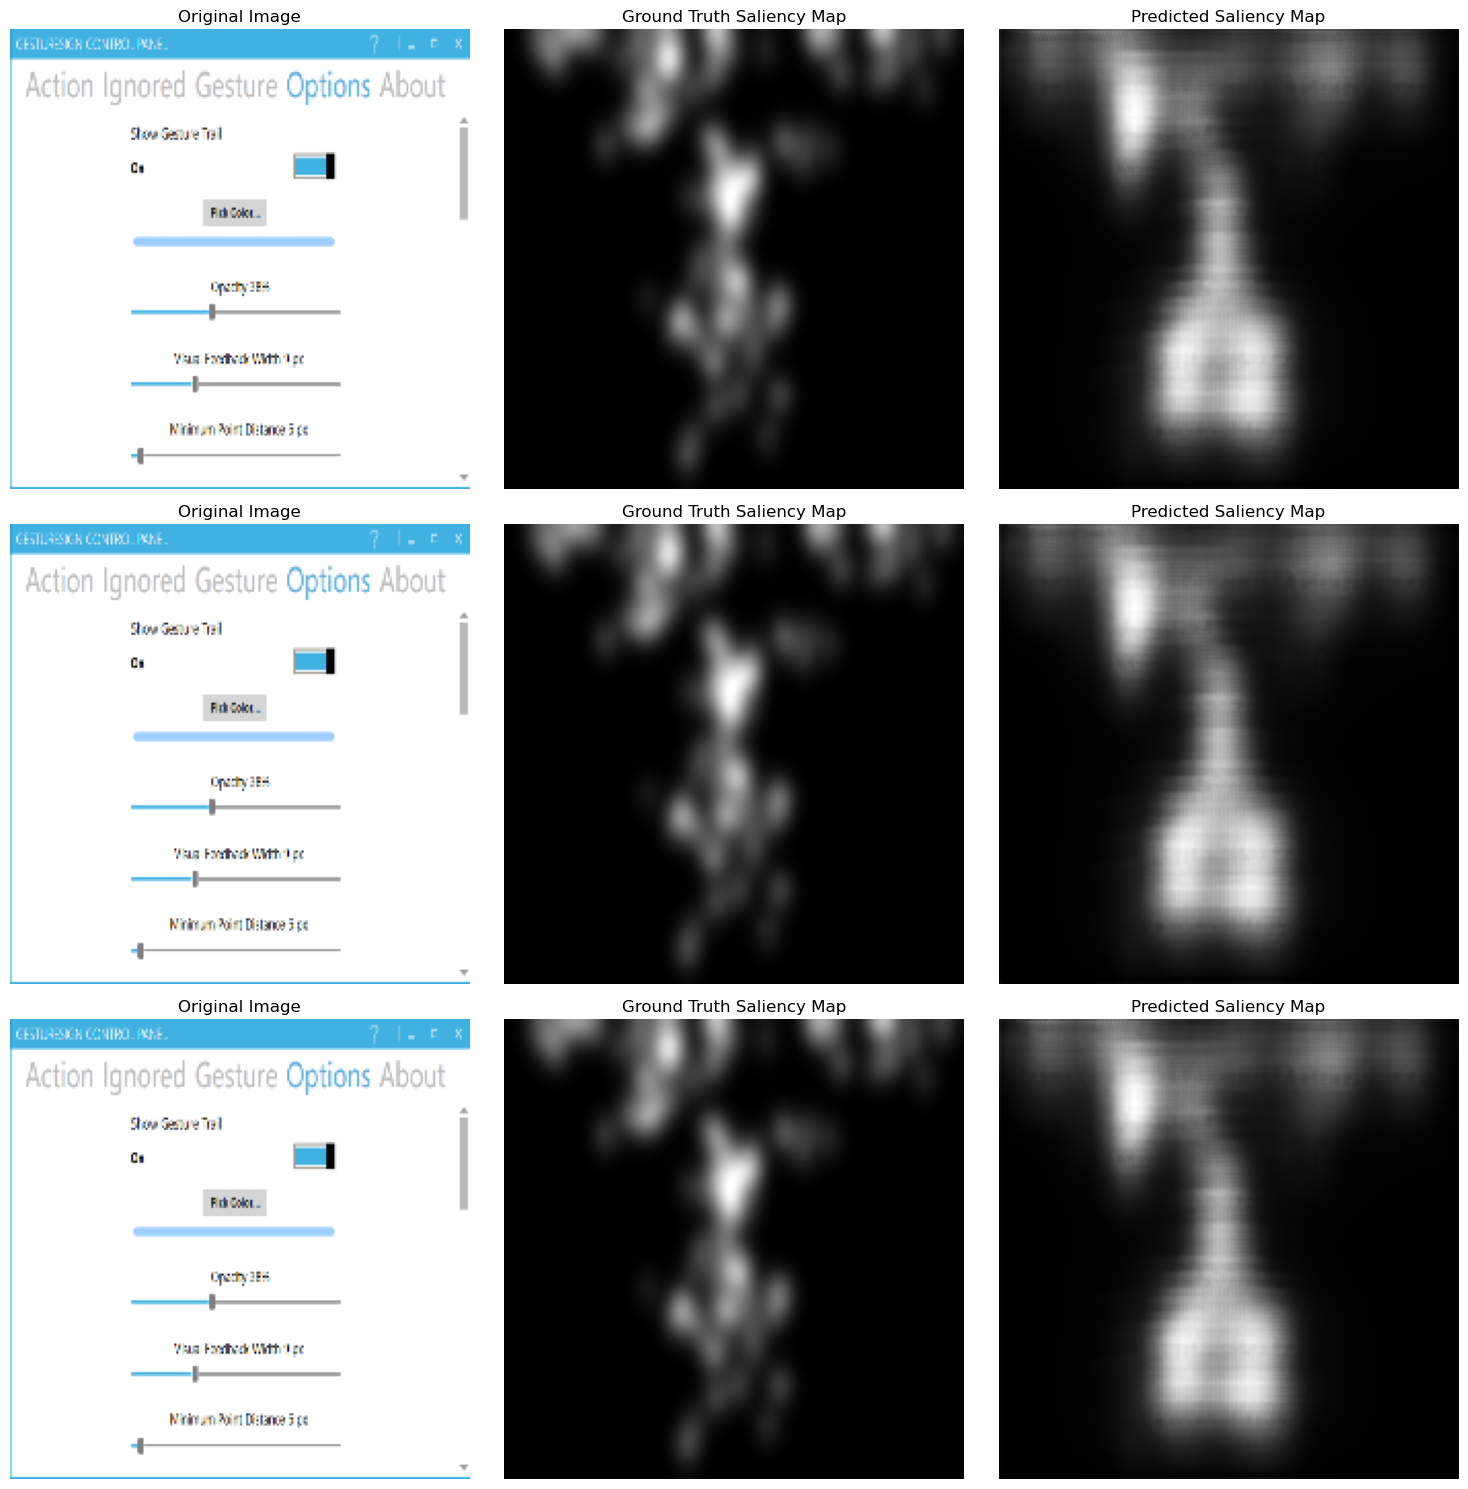

In [97]:
UMSI_kld = UMSI_simple(input_shape=(224, 224, 3))
UMSI_kld.compile(optimizer=opt, loss = kl_divergence, metrics='mae')
history = UMSI_kld.fit(train_data_gen, validation_data=valid_data_gen, epochs=12, steps_per_epoch=len(train_data_gen), callbacks=[early_stopping]) #Train the model and capture the history
plot_learning_curve(history)
visualize_results(UMSI_kld, test_data_gen, num_samples=3) # 5 random test examples

### Train with similarity loss

Epoch 1/12


2025-03-11 00:50:42.525230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - ETA: 0s - loss: -0.3673 - mae: 0.7505

2025-03-11 00:50:57.969809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 18s 756ms/step - loss: -0.3673 - mae: 0.7505 - val_loss: -0.3956 - val_mae: 0.7617
Epoch 2/12
17/17 [==============================] - 12s 705ms/step - loss: -0.3741 - mae: 0.6703 - val_loss: -0.3876 - val_mae: 0.3879
Epoch 3/12
17/17 [==============================] - 12s 690ms/step - loss: -0.3939 - mae: 0.6272 - val_loss: -0.4041 - val_mae: 0.7207
Epoch 4/12
17/17 [==============================] - 12s 684ms/step - loss: -0.3936 - mae: 0.6427 - val_loss: -0.3941 - val_mae: 0.8853
Epoch 5/12
17/17 [==============================] - 12s 689ms/step - loss: -0.3980 - mae: 0.6975 - val_loss: -0.4396 - val_mae: 0.5260
Epoch 6/12
17/17 [==============================] - 12s 686ms/step - loss: -0.3933 - mae: 0.6058 - val_loss: -0.3925 - val_mae: 0.8288
Epoch 7/12
17/17 [==============================] - 12s 687ms/step - loss: -0.3990 - mae: 0.6889 - val_loss: -0.3882 - val_mae: 0.9201
Epoch 8/12
17/17 [==============================] - 12s 700ms/step

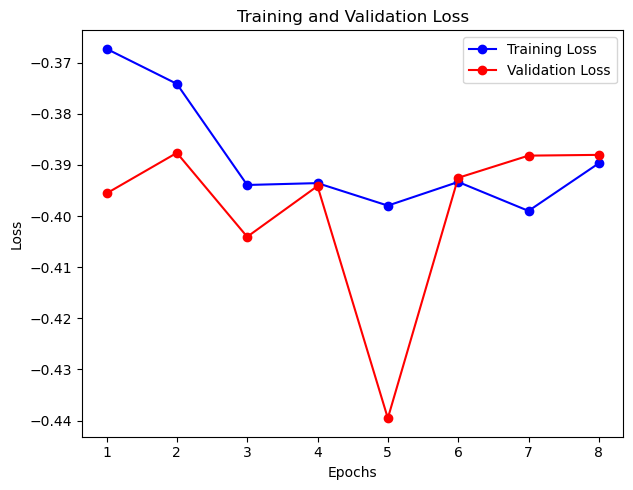

2025-03-11 00:52:25.363622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


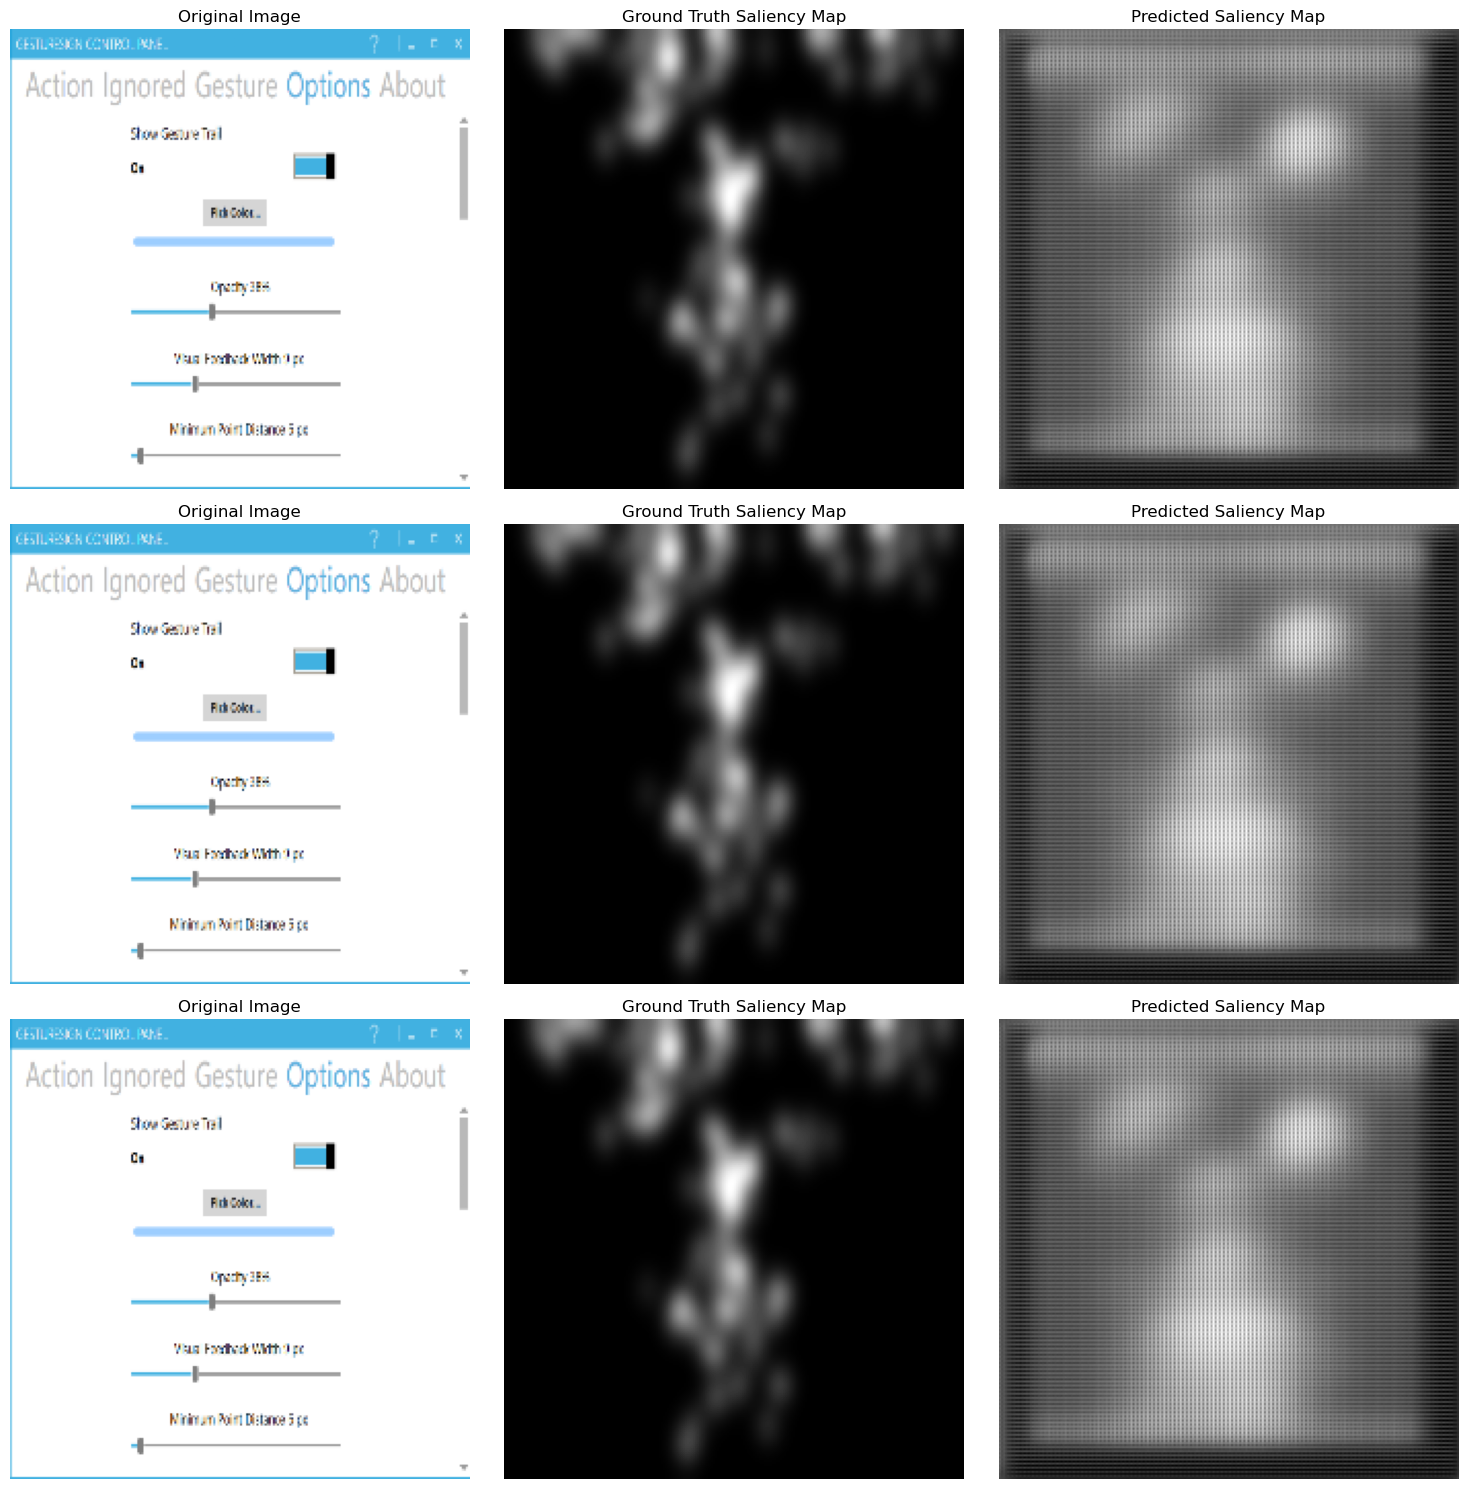

In [80]:
UMSI_sim = UMSI_simple(input_shape=(224, 224, 3))
UMSI_sim.compile(optimizer=opt, loss = similarity_loss, metrics='mae')
history = UMSI_sim.fit(train_data_gen, validation_data=valid_data_gen, epochs=12, steps_per_epoch=len(train_data_gen), callbacks=[early_stopping]) #Train the model and capture the history
plot_learning_curve(history)
visualize_results(UMSI_sim, test_data_gen, num_samples=3) # 5 random test examples

### Train with similarity (opposite) loss

Epoch 1/12


2025-03-11 10:55:51.916508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - ETA: 0s - loss: -0.9228 - mae: 0.4518

2025-03-11 10:56:07.439259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 18s 822ms/step - loss: -0.9228 - mae: 0.4518 - val_loss: -0.9498 - val_mae: 0.4154
Epoch 2/12
17/17 [==============================] - 13s 732ms/step - loss: -0.9408 - mae: 0.4266 - val_loss: -0.9493 - val_mae: 0.4312
Epoch 3/12
17/17 [==============================] - 13s 744ms/step - loss: -0.9493 - mae: 0.4064 - val_loss: -0.9491 - val_mae: 0.4084
Epoch 4/12
17/17 [==============================] - 15s 880ms/step - loss: -0.9468 - mae: 0.4241 - val_loss: -0.9487 - val_mae: 0.3928


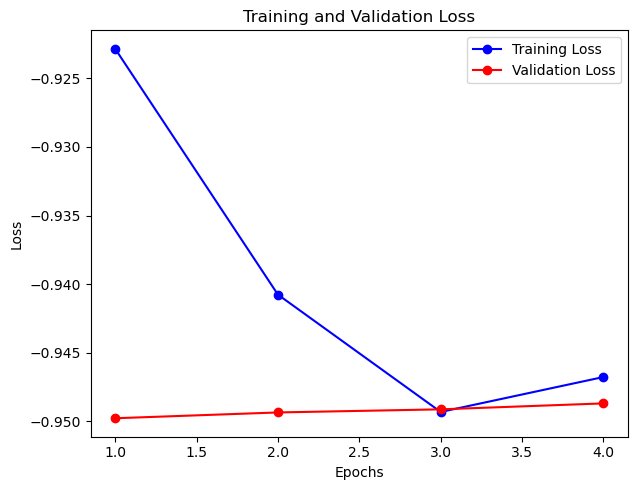

2025-03-11 10:56:50.842003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


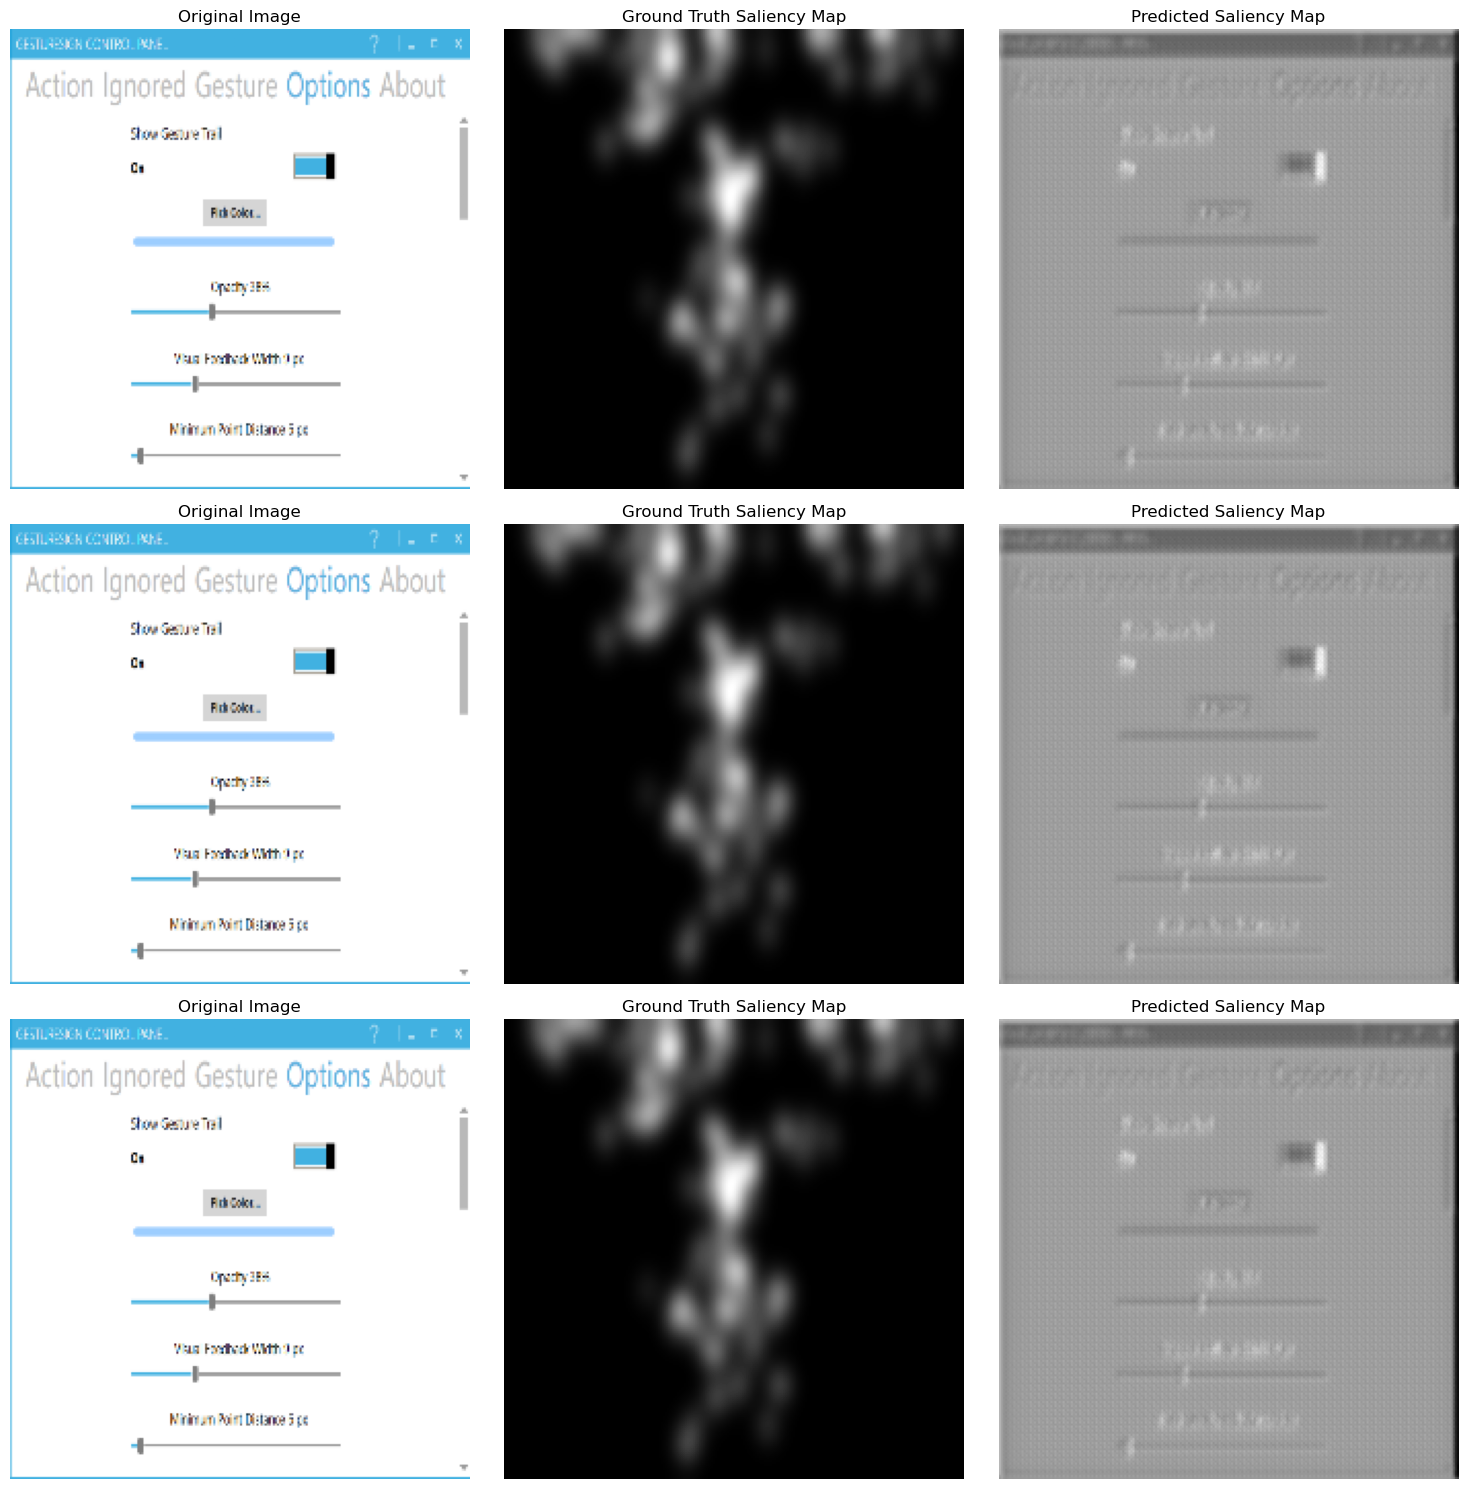

In [87]:
UMSI_sim_oppo = UMSI_simple(input_shape=(224, 224, 3))
UMSI_sim_oppo.compile(optimizer=opt, loss = similarity_opposite_loss, metrics='mae')
history = UMSI_sim_oppo.fit(train_data_gen, validation_data=valid_data_gen, epochs=12, steps_per_epoch=len(train_data_gen), callbacks=[early_stopping]) #Train the model and capture the history
plot_learning_curve(history)
visualize_results(UMSI_sim_oppo, test_data_gen, num_samples=3) # 5 random test examples

### Train with combined similarity loss (sum of the above two)

Epoch 1/12


2025-03-11 11:00:09.856806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - ETA: 0s - loss: -1.2905 - mae: 0.4294

2025-03-11 11:00:28.323210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 22s 943ms/step - loss: -1.2905 - mae: 0.4294 - val_loss: -1.3388 - val_mae: 0.3687
Epoch 2/12
17/17 [==============================] - 12s 699ms/step - loss: -1.3389 - mae: 0.3328 - val_loss: -1.3536 - val_mae: 0.2995
Epoch 3/12
17/17 [==============================] - 12s 694ms/step - loss: -1.3418 - mae: 0.2388 - val_loss: -1.3115 - val_mae: 0.4211
Epoch 4/12
17/17 [==============================] - 12s 704ms/step - loss: -1.3372 - mae: 0.3762 - val_loss: -1.3358 - val_mae: 0.3890
Epoch 5/12
17/17 [==============================] - 12s 698ms/step - loss: -1.3384 - mae: 0.3850 - val_loss: -1.3379 - val_mae: 0.3865


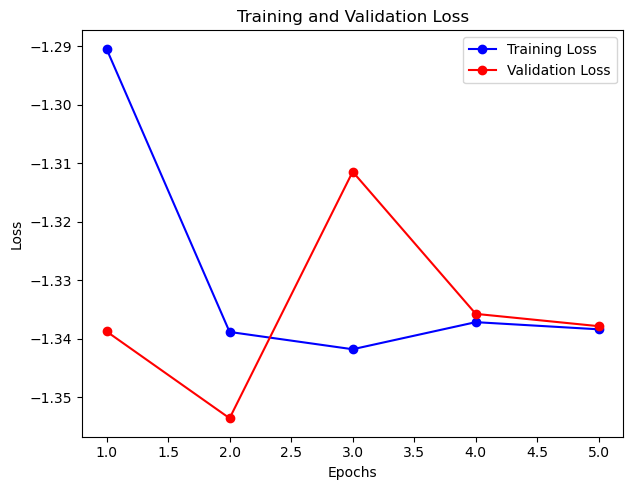

2025-03-11 11:01:19.516238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


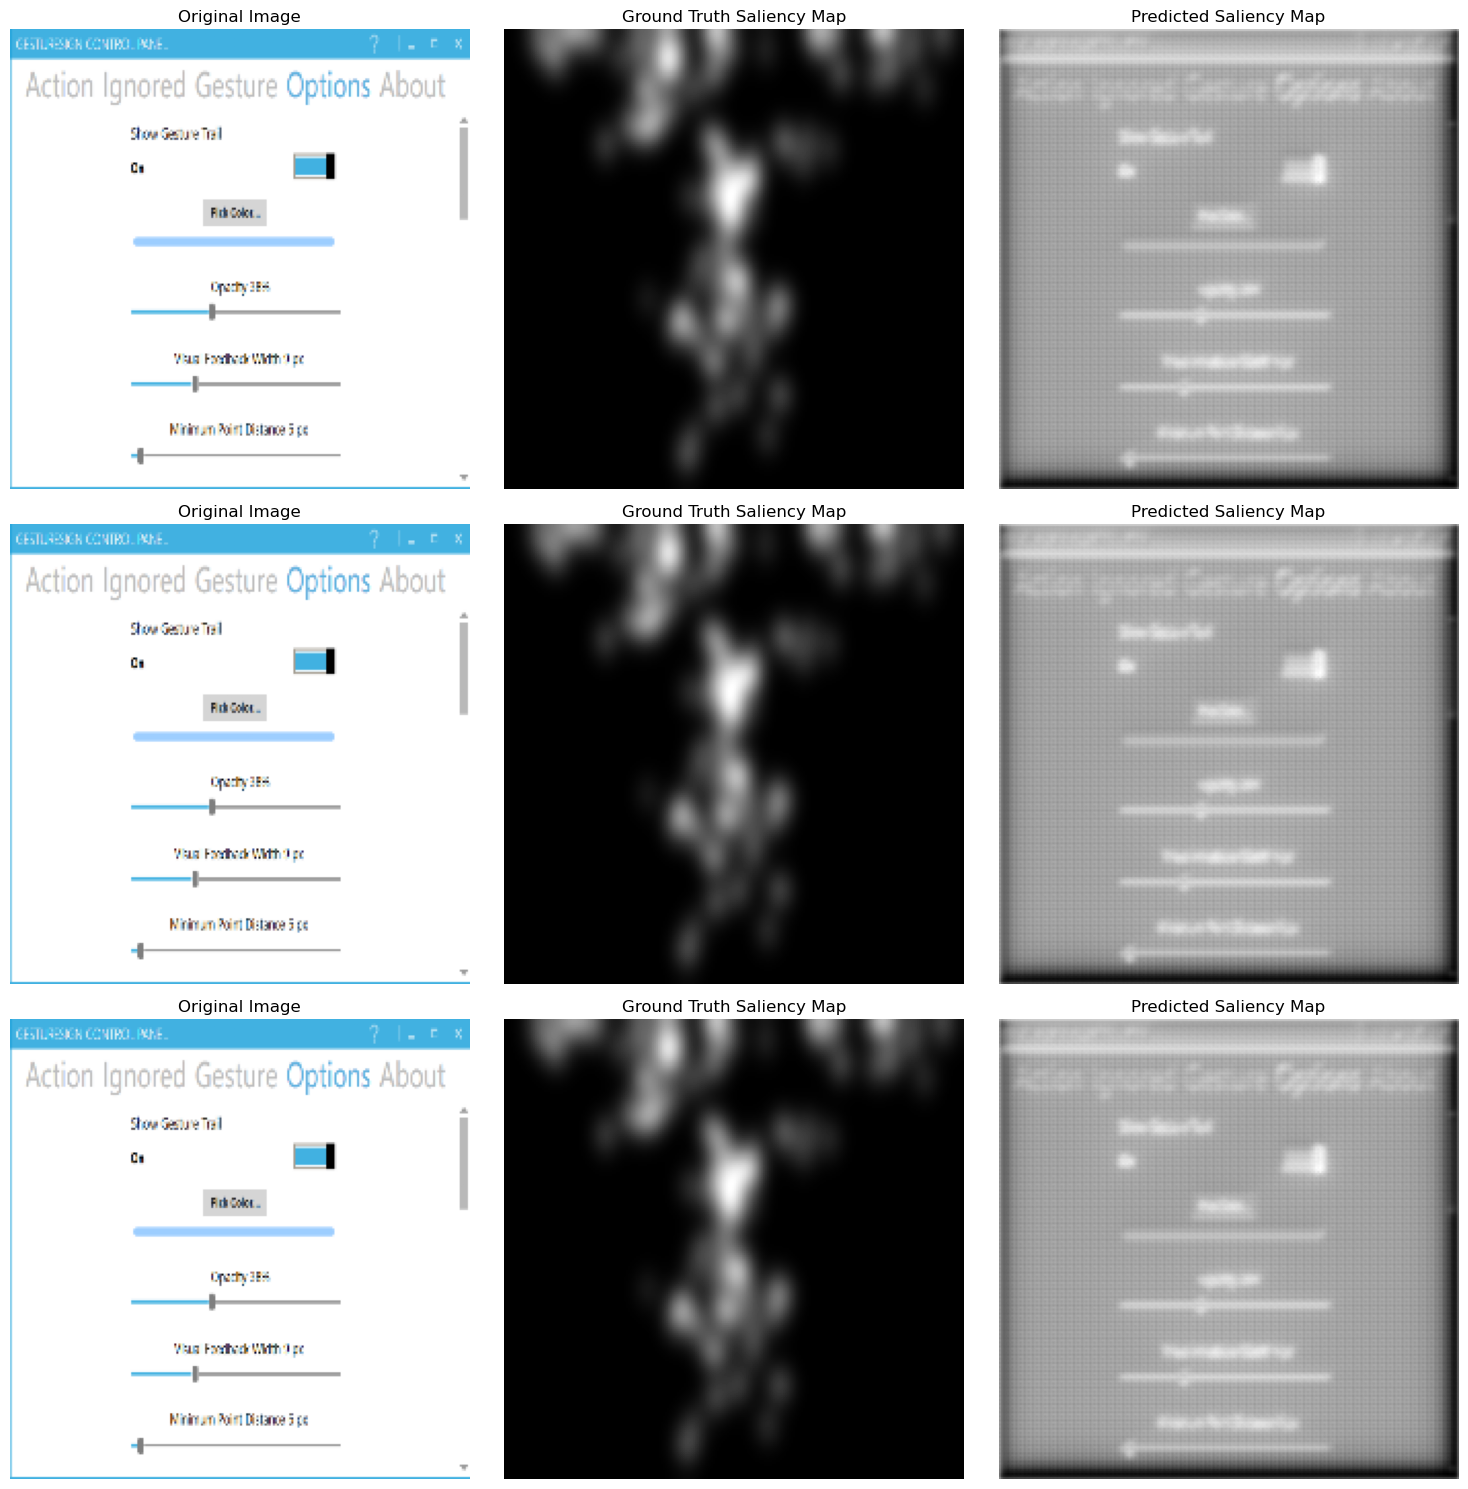

In [89]:
UMSI_sim_combined = UMSI_simple(input_shape=(224, 224, 3))
UMSI_sim_combined.compile(optimizer=opt, loss = combiined_similarity_loss, metrics='mae')
history = UMSI_sim_combined.fit(train_data_gen, validation_data=valid_data_gen, epochs=12, steps_per_epoch=len(train_data_gen), callbacks=[early_stopping]) #Train the model and capture the history
plot_learning_curve(history)
visualize_results(UMSI_sim_combined, test_data_gen, num_samples=3) # 5 random test examples

### Train with cosine similarity loss

Epoch 1/12


2025-03-11 11:56:12.984036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - ETA: 0s - loss: -0.5328 - mae: 0.4827

2025-03-11 11:56:28.248895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 18s 884ms/step - loss: -0.5328 - mae: 0.4827 - val_loss: -0.6215 - val_mae: 0.4758
Epoch 2/12
17/17 [==============================] - 13s 733ms/step - loss: -0.6516 - mae: 0.2747 - val_loss: -0.6833 - val_mae: 0.1589
Epoch 3/12
17/17 [==============================] - 13s 774ms/step - loss: -0.6836 - mae: 0.1944 - val_loss: -0.7037 - val_mae: 0.1617
Epoch 4/12
17/17 [==============================] - 12s 716ms/step - loss: -0.7105 - mae: 0.1262 - val_loss: -0.7083 - val_mae: 0.1611
Epoch 5/12
17/17 [==============================] - 13s 731ms/step - loss: -0.7138 - mae: 0.1296 - val_loss: -0.7178 - val_mae: 0.1096
Epoch 6/12
17/17 [==============================] - 13s 779ms/step - loss: -0.7133 - mae: 0.1337 - val_loss: -0.7234 - val_mae: 0.1180
Epoch 7/12
17/17 [==============================] - 14s 792ms/step - loss: -0.7255 - mae: 0.0994 - val_loss: -0.7275 - val_mae: 0.0806
Epoch 8/12
17/17 [==============================] - 14s 785ms/step

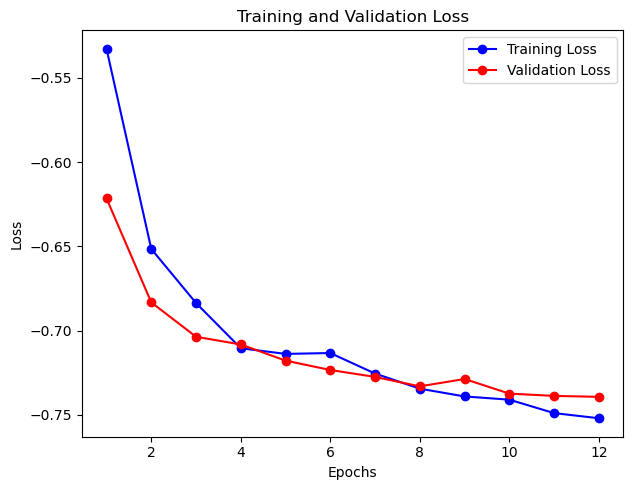

2025-03-11 11:58:52.397147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


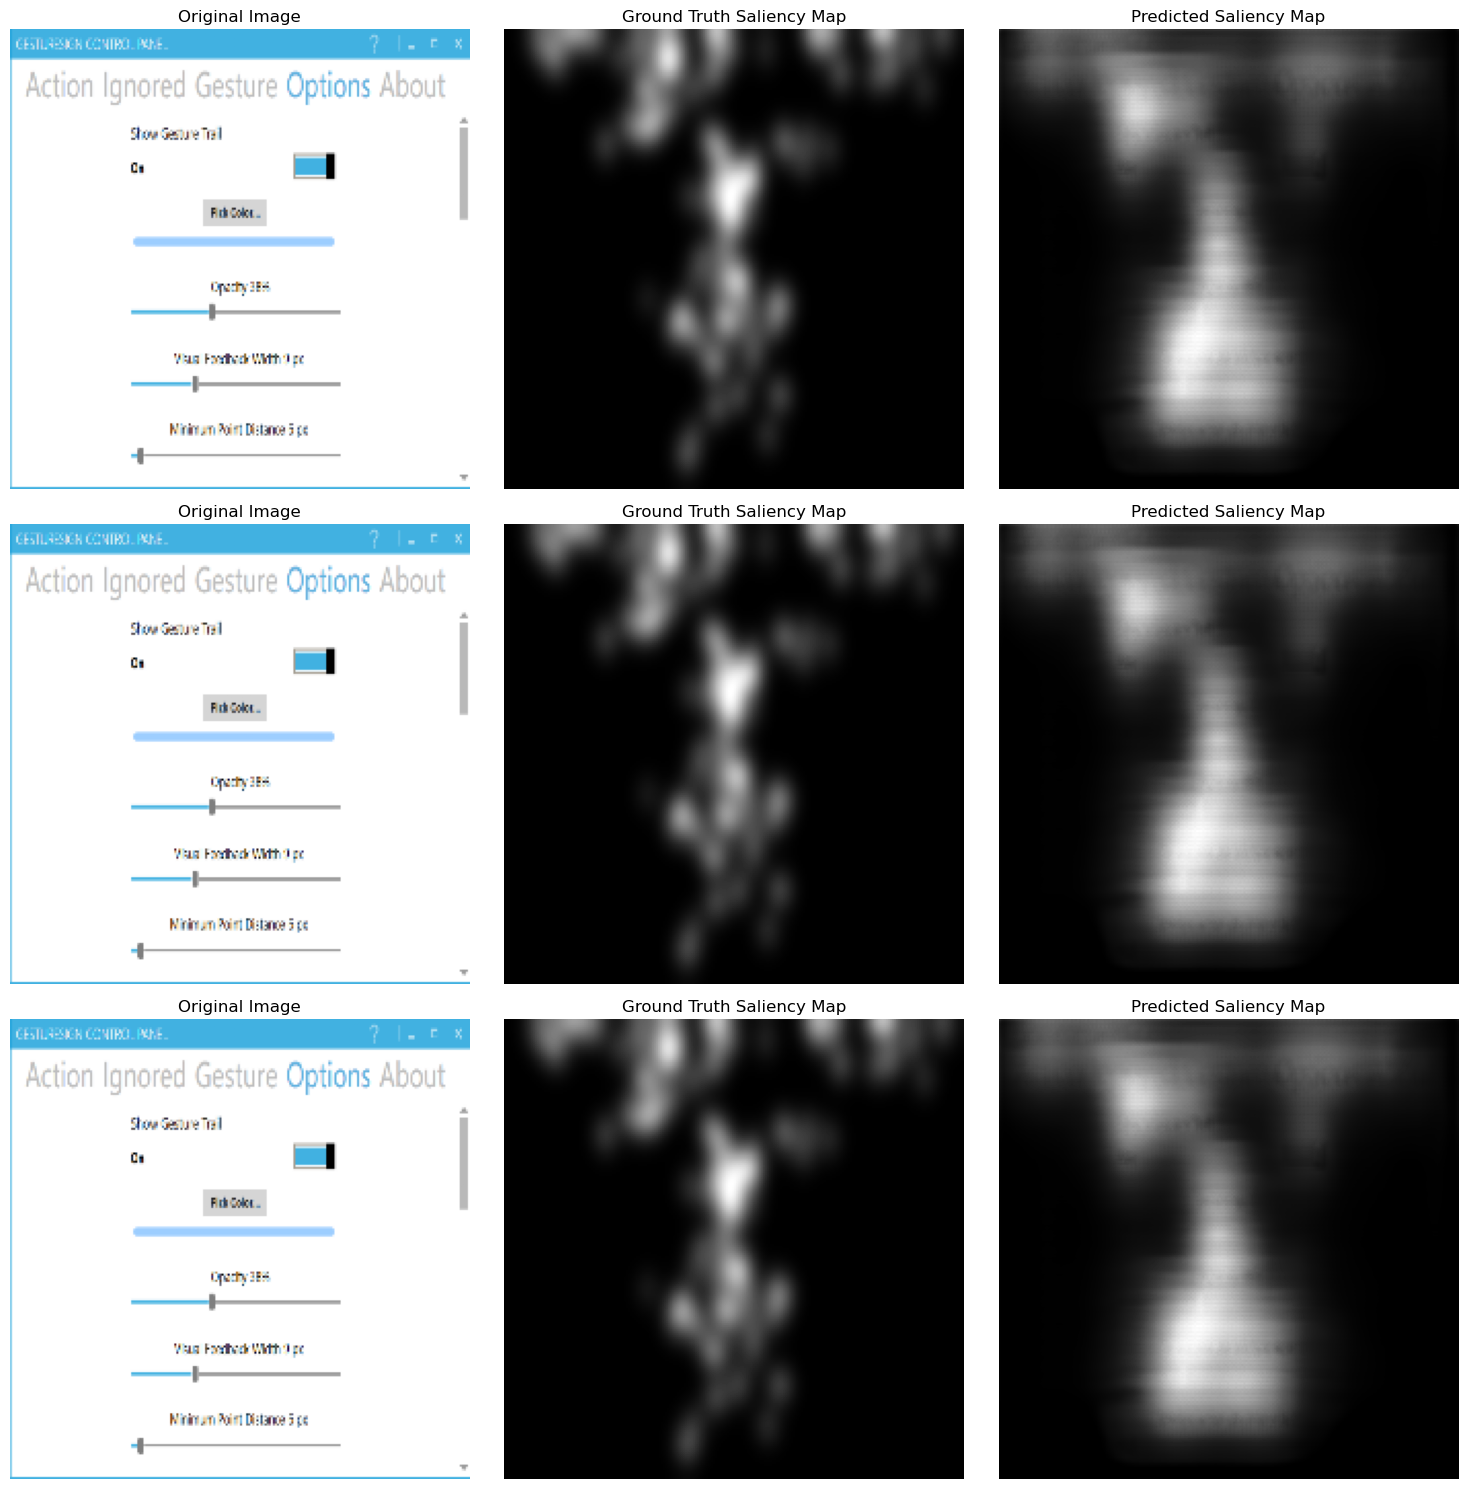

In [136]:
UMSI_cs = UMSI_simple(input_shape=(224, 224, 3))
UMSI_cs.compile(optimizer=opt, loss = cosine_similarity_loss, metrics='mae')
history = UMSI_cs.fit(train_data_gen, validation_data=valid_data_gen, epochs=12, steps_per_epoch=len(train_data_gen), callbacks=[early_stopping]) #Train the model and capture the history
plot_learning_curve(history)
visualize_results(UMSI_cs, test_data_gen, num_samples=3) # 5 random test examples


### Train with correlation coefficient loss

Epoch 1/12


2025-03-11 11:44:57.083064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - ETA: 0s - loss: -0.1420 - mae: 0.6438

2025-03-11 11:45:18.995664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 25s 871ms/step - loss: -0.1420 - mae: 0.6438 - val_loss: -0.2527 - val_mae: 0.4031
Epoch 2/12
17/17 [==============================] - 14s 834ms/step - loss: -0.3991 - mae: 0.5569 - val_loss: -0.4229 - val_mae: 0.4323
Epoch 3/12
17/17 [==============================] - 13s 722ms/step - loss: -0.4956 - mae: 0.4490 - val_loss: -0.5407 - val_mae: 0.5337
Epoch 4/12
17/17 [==============================] - 12s 717ms/step - loss: -0.5596 - mae: 0.4238 - val_loss: -0.5616 - val_mae: 0.4243
Epoch 5/12
17/17 [==============================] - 12s 703ms/step - loss: -0.5805 - mae: 0.4297 - val_loss: -0.5814 - val_mae: 0.4436
Epoch 6/12
17/17 [==============================] - 14s 794ms/step - loss: -0.5902 - mae: 0.4153 - val_loss: -0.5772 - val_mae: 0.4494
Epoch 7/12
17/17 [==============================] - 13s 770ms/step - loss: -0.6022 - mae: 0.3825 - val_loss: -0.5874 - val_mae: 0.4540
Epoch 8/12
17/17 [==============================] - 15s 885ms/step

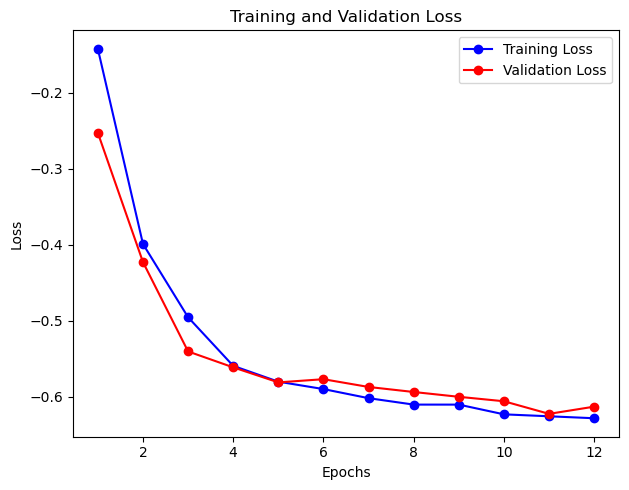

2025-03-11 11:47:49.680644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


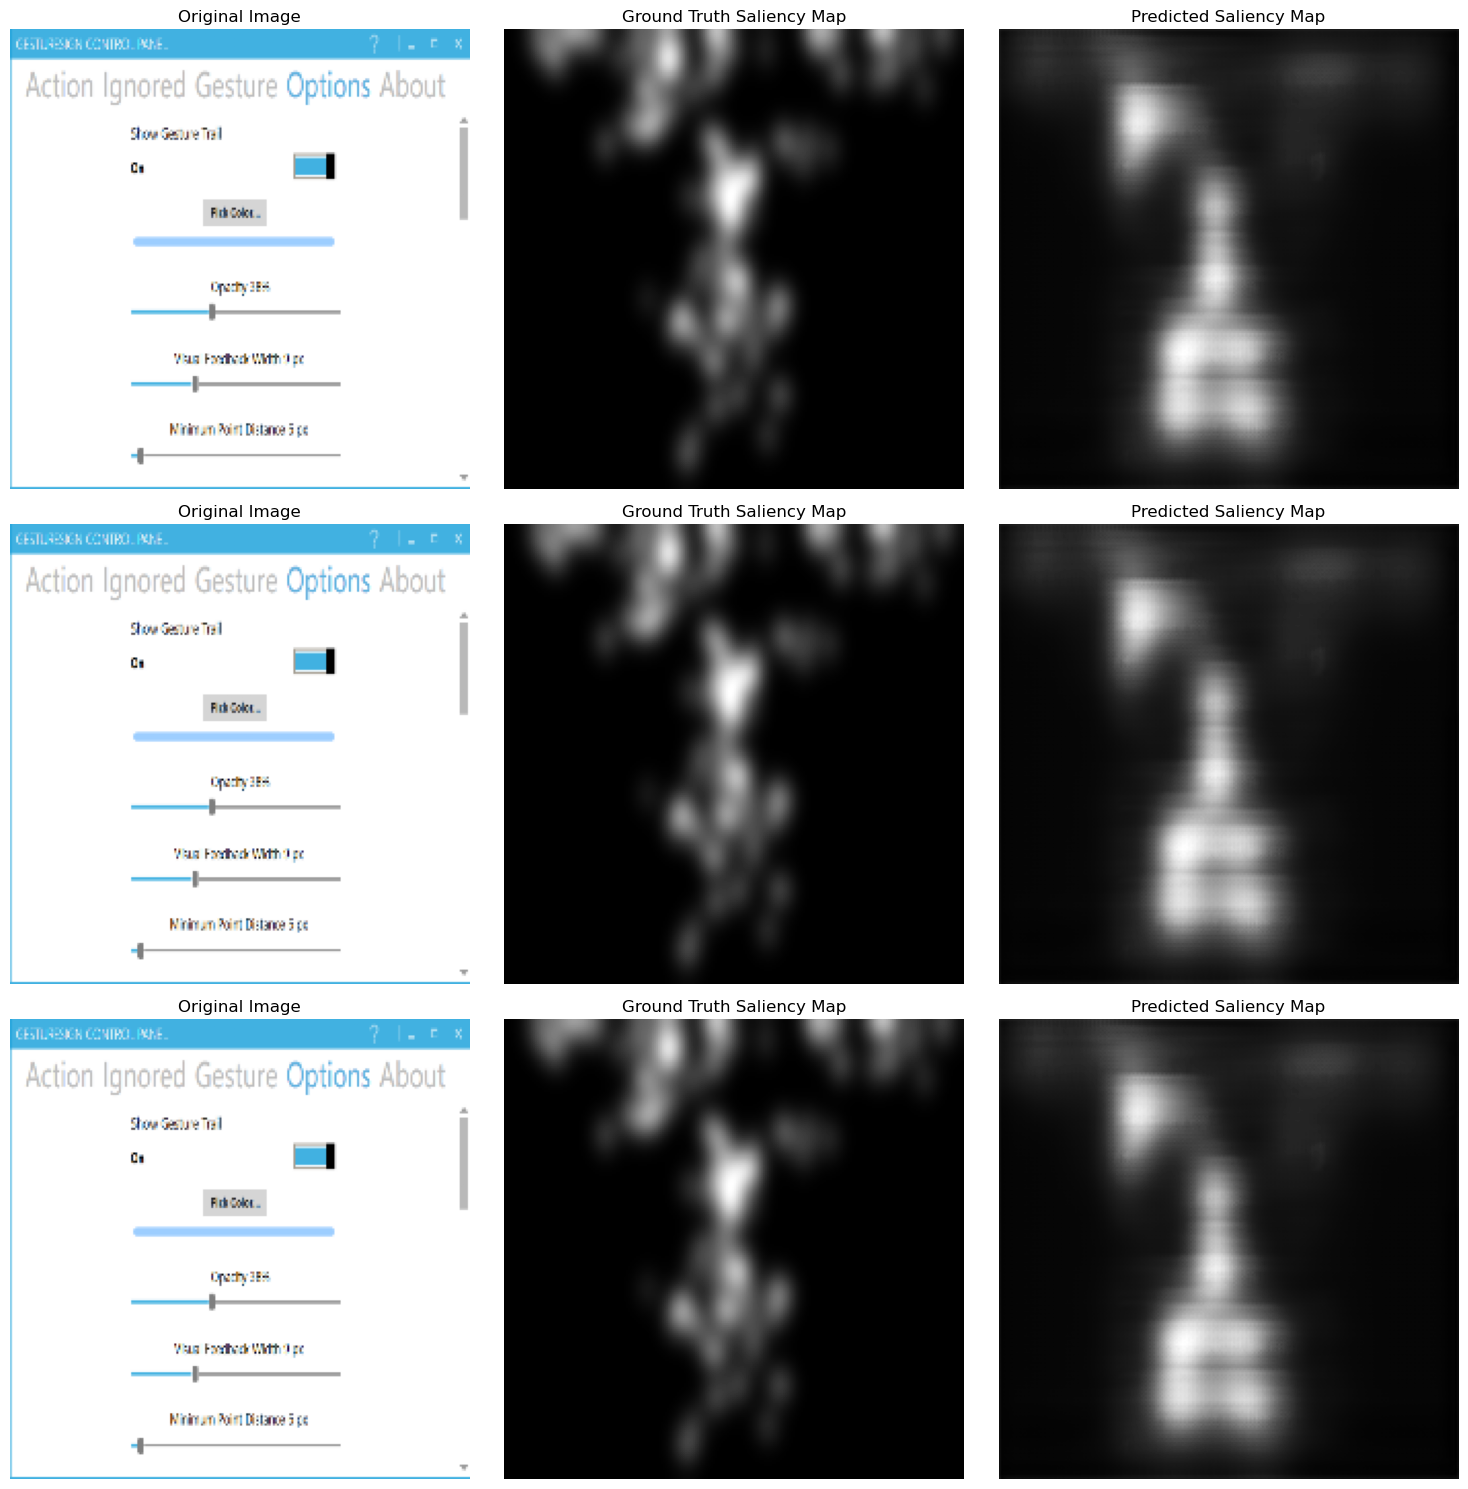

In [120]:
UMSI_cc = UMSI_simple(input_shape=(224, 224, 3))
UMSI_cc.compile(optimizer=opt, loss = correlation_coefficient_loss, metrics='mae')
history = UMSI_cc.fit(train_data_gen, validation_data=valid_data_gen, epochs=12, steps_per_epoch=len(train_data_gen), callbacks=[early_stopping]) #Train the model and capture the history
plot_learning_curve(history)
visualize_results(UMSI_cc, test_data_gen, num_samples=3) # 5 random test examples

### Train with SSIM score loss

In [46]:
from skimage.metrics import structural_similarity as ssim
def ssim_loss(y_true, y_pred):
    # Ensure the tensors are in the correct shape and type
    #y_true = tf.cast(y_true, tf.float32)
    #y_pred = tf.cast(y_pred, tf.float32)
    
    # Initialize a list to store the SSIM scores
    ssim_losses = []
    
    # Iterate over the batch
    for i in range(tf.shape(y_pred)[0]):
        # Extract the i-th image from the batch
        y_true_static = tf.ensure_shape(y_true[i, :, :, :], (IMG_SIZE[0], IMG_SIZE[1], 1))
        print(type(y_true_static))
        pred_image = tf.make_ndarray(tf.make_tensor_proto(y_pred[i, :, :, :]))
        true_image = tf.make_ndarray(tf.make_tensor_proto(y_true_static))

        
        # Compute the SSIM score for the i-th image
        score = ssim(true_image, pred_image, data_range=1.0)
        
        # Append the negated SSIM score to the list
        ssim_losses.append(-score)
    
    # Convert the list to a tensor and reshape it to (batch_size, 1)
    ssim_losses = tf.convert_to_tensor(ssim_losses, dtype=tf.float32)
    ssim_losses = tf.reshape(ssim_losses, (-1, 1))
    
    return ssim_losses

In [47]:
UMSI_ssim = UMSI_simple(input_shape=(224, 224, 3))
UMSI_ssim.compile(optimizer=opt, loss = ssim_loss, metrics='mae')
history = UMSI_ssim.fit(train_data_gen, validation_data=valid_data_gen, epochs=12, steps_per_epoch=len(train_data_gen), callbacks=[early_stopping]) #Train the model and capture the history
plot_learning_curve(history)
visualize_results(UMSI_ssim, test_data_gen, num_samples=3) # 5 random test examples

Epoch 1/12
<class 'tensorflow.python.framework.ops.Tensor'>


TypeError: in user code:

    File "/opt/anaconda3/envs/umsi++/lib/python3.9/site-packages/keras/engine/training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "/var/folders/_r/3m9nyp9x2_n9fz7sp9trt4b00000gn/T/ipykernel_25441/2252798197.py", line 15, in ssim_loss  *
        pred_image = tf.make_ndarray(tf.make_tensor_proto(y_pred[i, :, :, :]))

    TypeError: Expected any non-tensor type, but got a tensor instead.


# Test out different loss term combinations

In [20]:
# ------------------------------------ Loss Combinations used by UEyes Team ------------------------------------

def combined_loss_UEyes(y_true, y_pred):
    '''
    Uses functions implemented by us.

    Loss function that combines cc, nss and kl. Beacuse nss receives a different ground truth than kl and cc (maps),
        the function requires y_true to contains both maps. It has to be a tensor with dimensions [bs, 2, r, c, 1]. y_pred also
        has to be a tensor of the same dim, so the model should add a 5th dimension between bs and r and repeat the predict map
        twice along that dim.
    This method is adapted from the method in 'losses_keras2.py' written by the UEyes team.
    Returns a combined loss term with the specified weights that can be used in model.compile().
    '''

    # loss term weights specified by the UEyes team
    kl_weight=10.0
    cc_weight=3.0
    sim_weight=1.0
    nss_weight=0.5
    mse_weight=1

    # compute loss terms
    k = kl_divergence(y_true, y_pred)
    c = correlation_coefficient(y_true, y_pred) # cc becoming nan values after 8 passes???
    n = nss(y_true, y_pred)
    s = similarity(y_true, y_pred)
    m = mse(y_true, y_pred) # tf.reduce_mean(tf.square(y_true - y_pred))
    
    # combined loss
    #return kl_weight*k - nss_weight*n + mse_weight*m #- cc_weight*c - sim_weight*s
    return kl_weight*k - nss_weight*n - sim_weight*s - cc_weight*c  + mse_weight*m 


def combined_loss_UEyes_2(y_true, y_pred):
    '''
    Uses functions implemented by us.

    Loss function that combines cc, nss and kl. Beacuse nss receives a different ground truth than kl and cc (maps),
        the function requires y_true to contains both maps. It has to be a tensor with dimensions [bs, 2, r, c, 1]. y_pred also
        has to be a tensor of the same dim, so the model should add a 5th dimension between bs and r and repeat the predict map
        twice along that dim.
    This method is adapted from the method in 'losses_keras2.py' written by the UEyes team.
    Returns a combined loss term with the specified weights that can be used in model.compile().
    '''

    # loss term weights specified by the UEyes team
    kl_weight=10.0
    nss_weight=0.5
    mse_weight=1

    # compute loss terms
    k = kl_divergence(y_true, y_pred)
    n = nss(y_true, y_pred)
    m = mse(y_true, y_pred) # tf.reduce_mean(tf.square(y_true - y_pred))
    
    # combined loss
    return kl_weight*k - nss_weight*n + mse_weight*m 

# ------------------------------------ New Loss Combinations to Consider ------------------------------------
def combined_loss(y_true, y_pred):
    '''
    Returns a combined loss term with the specified weights that can be used in model.compile().
    TODO: add the new loss terms to consider
    '''

    # loss term weights
    kl_weight=1.0 # kl is small in terms of magnitude
    cc_weight=1.0
    #sim_weight=1.0
    #sim_oppo_weight=1.0
    nss_weight=1.0
    #mse_weight=1
    #mae_weight=1
    cs_weight=0.5

    # compute loss terms
    k = kl_divergence(y_true, y_pred)
    c = correlation_coefficient_loss(y_true, y_pred) # cc becoming nan values after 8 passes???
    n = nss_loss(y_true, y_pred)
    #s1 = similarity(y_true, y_pred)
    #s2 = similarity_opposite(y_true, y_pred)
    #m = mse(y_true, y_pred)
    #m = mae(y_true, y_pred)
    cs = cosine_similarity_loss(y_true, y_pred)
    
    # combined loss
    return kl_weight*k + nss_weight*n + cc_weight*c + cs_weight*cs # + mae_weight*m - sim_weight*s1 - sim_oppo_weight*s2

Epoch 1/12


2025-03-11 12:52:18.307194: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2025-03-11 12:52:20.046224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - ETA: 0s - loss: -1.4135 - mae: 0.5172

2025-03-11 12:52:34.875961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 18s 799ms/step - loss: -1.4135 - mae: 0.5172 - val_loss: -1.8435 - val_mae: 0.4924
Epoch 2/12
17/17 [==============================] - 14s 829ms/step - loss: -1.8770 - mae: 0.5262 - val_loss: -1.9211 - val_mae: 0.4920
Epoch 3/12
17/17 [==============================] - 13s 783ms/step - loss: -1.9140 - mae: 0.5059 - val_loss: -1.9481 - val_mae: 0.4997
Epoch 4/12
17/17 [==============================] - 15s 827ms/step - loss: -1.9896 - mae: 0.5247 - val_loss: -1.9856 - val_mae: 0.4651
Epoch 5/12
17/17 [==============================] - 13s 747ms/step - loss: -2.0425 - mae: 0.4988 - val_loss: -2.0065 - val_mae: 0.4392
Epoch 6/12
17/17 [==============================] - 13s 745ms/step - loss: -2.0896 - mae: 0.4717 - val_loss: -2.0686 - val_mae: 0.5020
Epoch 7/12
17/17 [==============================] - 14s 769ms/step - loss: -2.0959 - mae: 0.4647 - val_loss: -2.0653 - val_mae: 0.5094
Epoch 8/12
17/17 [==============================] - 13s 726ms/step

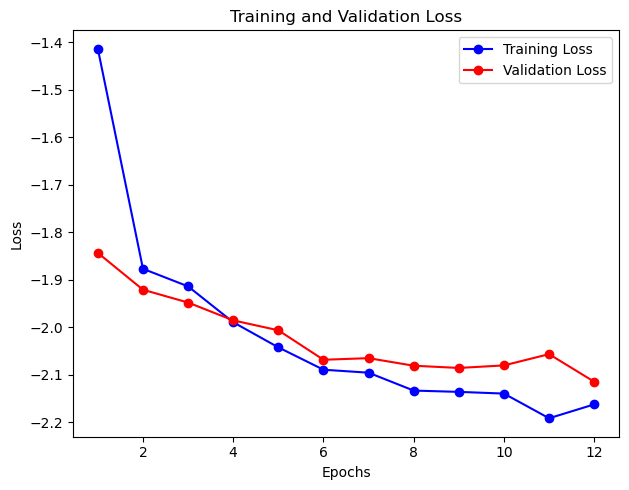

2025-03-11 12:55:05.623936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


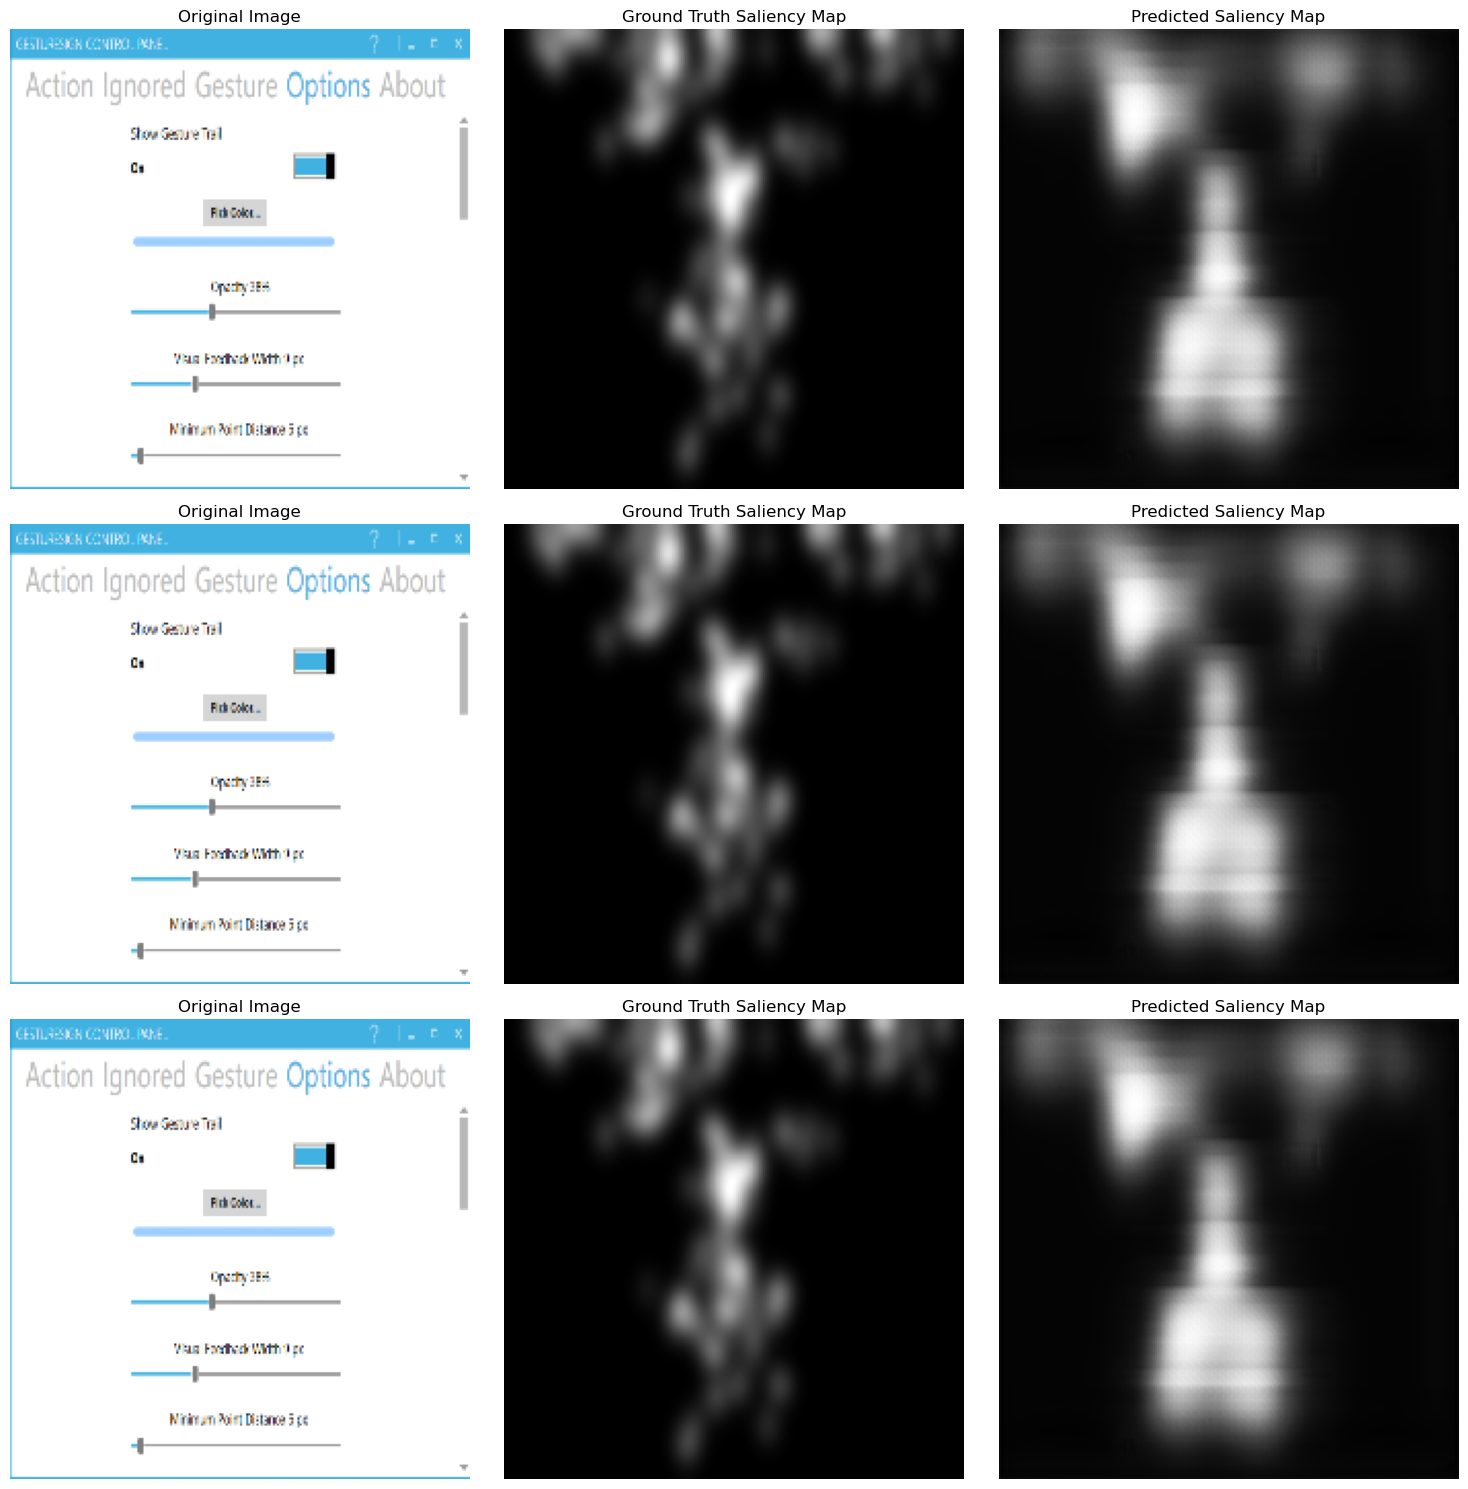

In [ ]:
'''
kl_weight=10.0 # since kl is small in terms of magnitude
cc_weight=1.0
nss_weight=1.0
cs_weight=0.5
'''
UMSI_1 = UMSI_simple(input_shape=(224, 224, 3))
UMSI_1.compile(optimizer=opt, loss = combined_loss, metrics='mae')
history = UMSI_1.fit(train_data_gen, validation_data=valid_data_gen, epochs=12, steps_per_epoch=len(train_data_gen), callbacks=[early_stopping]) #Train the model and capture the history
plot_learning_curve(history)
visualize_results(UMSI_1, test_data_gen, num_samples=3) # 5 random test examples

Epoch 1/12


2025-03-11 13:01:13.107669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - ETA: 0s - loss: -1.2931 - mae: 0.5839

2025-03-11 13:01:32.009031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 24s 984ms/step - loss: -1.2931 - mae: 0.5839 - val_loss: -1.7823 - val_mae: 0.4778
Epoch 2/12
17/17 [==============================] - 15s 861ms/step - loss: -1.8460 - mae: 0.5105 - val_loss: -1.9363 - val_mae: 0.4605
Epoch 3/12
17/17 [==============================] - 14s 793ms/step - loss: -1.9471 - mae: 0.4853 - val_loss: -2.0292 - val_mae: 0.4673
Epoch 4/12
17/17 [==============================] - 16s 929ms/step - loss: -2.0377 - mae: 0.4901 - val_loss: -2.0422 - val_mae: 0.4756
Epoch 5/12
17/17 [==============================] - 17s 973ms/step - loss: -2.0759 - mae: 0.4803 - val_loss: -2.0601 - val_mae: 0.4750
Epoch 6/12
17/17 [==============================] - 14s 833ms/step - loss: -2.1117 - mae: 0.4625 - val_loss: -2.0928 - val_mae: 0.4538
Epoch 7/12
17/17 [==============================] - 15s 861ms/step - loss: -2.1138 - mae: 0.4454 - val_loss: -2.1002 - val_mae: 0.4664
Epoch 8/12
17/17 [==============================] - 18s 1s/step - 

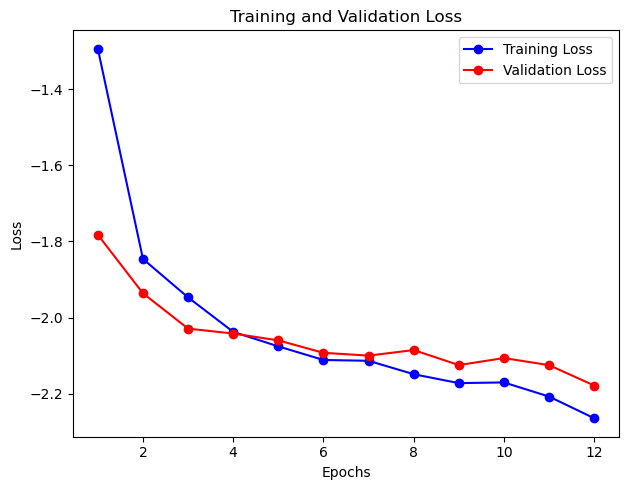

2025-03-11 13:04:22.998446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


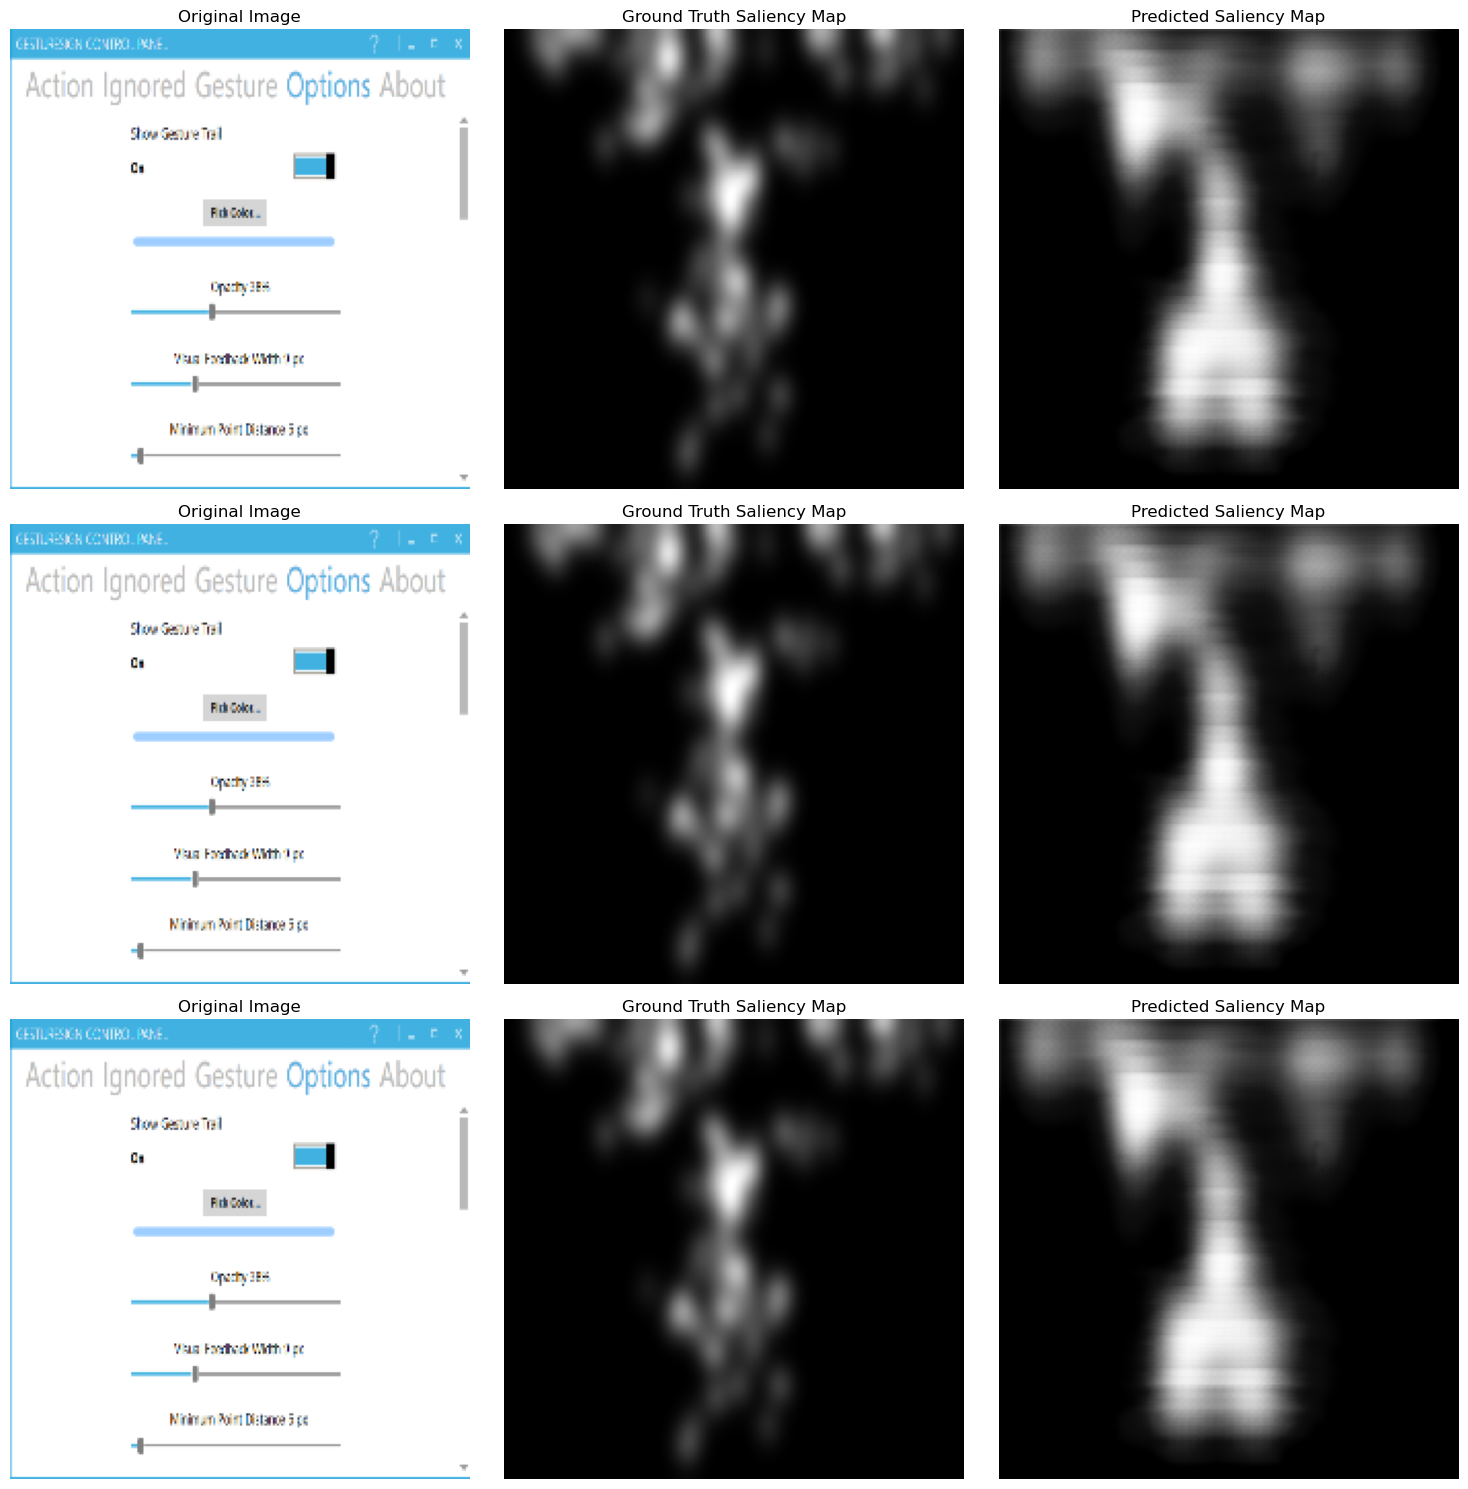

In [21]:
'''
kl_weight=1.0 # without scaling kld
cc_weight=1.0
nss_weight=1.0
cs_weight=0.5
'''
UMSI_2 = UMSI_simple(input_shape=(224, 224, 3))
UMSI_2.compile(optimizer=opt, loss = combined_loss, metrics='mae')
history = UMSI_2.fit(train_data_gen, validation_data=valid_data_gen, epochs=12, steps_per_epoch=len(train_data_gen), callbacks=[early_stopping]) #Train the model and capture the history
plot_learning_curve(history)
visualize_results(UMSI_2, test_data_gen, num_samples=3) # 5 random test examples